In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats
from functools import reduce
import statsmodels
import seaborn as sns
import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, savefig, despine

from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table

In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-allcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [5]:
data.keys()

Index(['action', 'baseline', 'entity', 'frequency', 'i', 'ii', 'session',
       'stim_location', 'stimulated', 'tag', 'date', 'entity_date', 'Hz11',
       'Hz30', 'channel_group', 'max_depth_delta', 'max_dissimilarity',
       'unit_id', 'unit_idnum', 'unit_name', 'average_rate', 'speed_score',
       'out_field_mean_rate', 'in_field_mean_rate', 'max_field_mean_rate',
       'max_rate', 'sparsity', 'selectivity', 'interspike_interval_cv',
       'burst_event_ratio', 'bursty_spike_ratio', 'gridness', 'border_score',
       'information_rate', 'information_specificity', 'head_mean_ang',
       'head_mean_vec_len', 'spacing', 'orientation', 'field_area',
       'theta_score', 'unit_day', 't_e_peak', 'p_e_peak', 't_i_peak',
       'p_i_peak', 'border_score_threshold', 'gridness_threshold',
       'head_mean_ang_threshold', 'head_mean_vec_len_threshold',
       'information_rate_threshold', 'speed_score_threshold', 'specificity',
       'half_width', 'peak_to_trough', 'average_firing_rate

# Calculate statistics

In [6]:
columns = [
    'average_rate', 
#     'spatial_average_rate',
    'gridness', 
    'sparsity', 
    'selectivity',
    'information_rate',
    'information_specificity',
    'max_rate',  
    'interspike_interval_cv', 
    'burst_event_ratio',  
    'in_field_mean_rate', 
    'out_field_mean_rate',
    'max_field_mean_rate',
    'specificity', 
    'speed_score', 
    'spacing', 
    'field_area', 
    'head_mean_vec_len', 
    'border_score'
]

In [7]:
results, labels = make_paired_tables(data, columns)

In [8]:
results['gridcell']['average_rate']

entity  unit_idnum  channel_group    date  Baseline I      11 Hz  \
51     1833           8              0   20719    7.900527        NaN   
85     1833          13              0   20719         NaN   5.415361   
86     1833          14              0   20719         NaN  16.681112   
58     1833          23              0  200619   16.171078        NaN   
127    1833          26              0  200619         NaN        NaN   
..      ...         ...            ...     ...         ...        ...   
139    1849         835              4  150319         NaN        NaN   
43     1849         851              5   60319   23.736187        NaN   
65     1849         932              7  280219    5.661950        NaN   
74     1849         937              7  280219         NaN   9.485790   
105    1849         939              7  280219         NaN        NaN   

     Baseline II     30 Hz  
51           NaN       NaN  
85      6.456882  9.526984  
86     16.498883       NaN  
58           NaN       NaN  
127     6.990117  6.953565  
..           ...       ...  
139          NaN  3.680061  
43           NaN       NaN  
65           NaN       NaN  
74           NaN       NaN  
105    12.721755       NaN  

[137 rows x 8 columns]

In [9]:
# TODO: control for information rate

# Create nice table

In [24]:
def LMM(df, case, control, key='val', use_unit_id=True, method=['powell', "lbfgs", 'bfgs', 'cg', 'basinhopping']):
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    dd = pd.DataFrame()
    dd[key] = df[case]
    dd['label'] = 0
    dd['entity'] = df['entity']

    ddd = pd.DataFrame()
    ddd[key] = df[control]
    ddd['entity'] = df['entity']
    if use_unit_id:
        dd['unit_idnum'] = df['unit_idnum']
        ddd['unit_idnum'] = df['unit_idnum']
    ddd['label'] = 1
    dff = pd.concat([dd, ddd]).replace([np.inf, -np.inf], np.nan).dropna().reset_index()

    if dff.empty:
        return [np.nan] * 4
    
    if use_unit_id:
        vc = {'unit_idnum': '0 + C(unit_idnum)'}
    else:
        vc = None
        
    mdf = smf.mixedlm(f"{key} ~ label", dff, groups="entity", missing='drop', vc_formula=vc, re_formula='label').fit(method=method)    
    low, high = mdf.conf_int(alpha=0.05).iloc[1,:].values
    pval = mdf.pvalues[1]
    marker = ''
    if np.isnan(pval):
        marker = '*'
        mdf = smf.mixedlm(f"{key} ~ label", dff, groups="entity", missing='drop', re_formula='label').fit(method=method)
        low, high = mdf.conf_int(alpha=0.05).iloc[1,:].values
        pval = mdf.pvalues[1]
        
    if np.isnan(pval):
        marker = '**'
        mdf = smf.mixedlm(f"{key} ~ label", dff, groups="entity", missing='drop').fit(method=method)
        low, high = mdf.conf_int(alpha=0.05).iloc[1,:].values
        pval = mdf.pvalues[1]
    
    return pval, low, high, mdf, marker

pval, low, high, mdf = LMM(results['gridcell']['speed_score'], 'Baseline II', '30 Hz')

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [25]:
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: val     
No. Observations: 81      Method:             REML    
No. Groups:       4       Scale:              0.0040  
Min. group size:  3       Log-Likelihood:     100.7347
Max. group size:  60      Converged:          Yes     
Mean group size:  20.2                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.098    0.022  4.542 0.000  0.056  0.141
label       -0.013    0.014 -0.874 0.382 -0.041  0.016
entity Var   0.001    0.020                           
======================================================

"""

In [18]:
stat = {}
stat_values = {}
for cell_type, result in results.items():
    stat[cell_type], stat_values[cell_type] = make_statistics_table(result, labels)

In [37]:
stat['gridcell'].keys()

Index(['Average rate', 'Gridness', 'Sparsity', 'Selectivity',
       'Information rate', 'Information specificity', 'Max rate',
       'Interspike interval cv', 'Burst event ratio', 'In-field mean rate',
       'Out-field mean rate', 'Max-field mean rate', 'Specificity',
       'Speed score', 'Spacing', 'Field area', 'Head mean vec len',
       'Border score'],
      dtype='object')

In [42]:
row_keys = {
    'gridcell': ['Average rate', 'Gridness', 'Sparsity', 'Selectivity',
       'Information rate', 'Information specificity', 'Max rate',
       'Interspike interval cv', 'Burst event ratio', 'In-field mean rate',
       'Out-field mean rate', 'Max-field mean rate', 'Specificity',
       'Speed score', 'Spacing', 'Field area', 'Head mean vec len',
       'Border score'],
    'ns_inhibited': ['Average rate', 'Max rate',
       'Interspike interval cv', 'Burst event ratio', 
       'Speed score', 'Head mean vec len', 'Border score'],
    'ns_not_inhibited': ['Average rate', 'Max rate',
       'Interspike interval cv', 'Burst event ratio', 
       'Speed score', 'Head mean vec len', 'Border score'],
    'bs_not_gridcell': ['Average rate', 'Max rate',
       'Interspike interval cv', 'Burst event ratio', 
       'Speed score', 'Head mean vec len', 'Border score']
}

In [50]:
key = 'bs_not_gridcell'

In [51]:
print(stat[key].T.loc[row_keys[key],['Baseline I','11 Hz']].to_latex())
print()
print(stat[key].T.loc[row_keys[key],['Baseline II','30 Hz']].to_latex())
print()
print(stat[key].T.loc[row_keys[key],['LMM Baseline I - 11 Hz','LMM Baseline II - 30 Hz']].to_latex())
print()
print(stat[key].T.loc[row_keys[key],['LMM Baseline I - Baseline II','LMM 11 Hz - 30 Hz']].to_latex())

\begin{tabular}{lll}
\toprule
{} &             Baseline I &                   11 Hz \\
\midrule
Average rate           &     10.1 ± 0.578 (211) &      11.2 ± 0.631 (228) \\
Max rate               &        31 ± 1.32 (211) &       30.4 ± 1.38 (228) \\
Interspike interval cv &     2.47 ± 0.117 (211) &     1.88 ± 0.0606 (228) \\
Burst event ratio      &  0.218 ± 0.00601 (211) &   0.208 ± 0.00791 (228) \\
Speed score            &  0.105 ± 0.00912 (211) &  0.0925 ± 0.00723 (228) \\
Head mean vec len      &  0.0998 ± 0.0065 (211) &  0.0801 ± 0.00526 (228) \\
Border score           &  0.235 ± 0.00669 (211) &   0.227 ± 0.00669 (228) \\
\bottomrule
\end{tabular}


\begin{tabular}{lll}
\toprule
{} &             Baseline II &                  30 Hz \\
\midrule
Average rate           &       10.2 ± 0.73 (155) &     12.4 ± 0.731 (161) \\
Max rate               &       30.3 ± 1.75 (155) &      35.3 ± 1.87 (161) \\
Interspike interval cv &      2.26 ± 0.151 (155) &    1.82 ± 0.0593 (161) \\
Burst even

In [13]:
for cell_type, sta in stat.items():
    sta.T.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    sta.T.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [14]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

## Cumulative density plots

In [14]:
title_xlabel = {
    'information_rate': ('Spatial information','bits/s'),
    'information_specificity': ("Spatial information specificity","bits/spike"),
    'specificity': ("Spatial specificity", ""),
    'average_rate': ("Average rate", "spikes/s"),
#     'spatial_average_rate': ("Spatial average rate", "spikes/s"),
    'max_rate': ("Max rate", "spikes/s"),
    'interspike_interval_cv': ("ISI CV", "Coefficient of variation"),
    'in_field_mean_rate': ("In-field rate", "spikes/s"),
    'out_field_mean_rate': ("Out-of-field rate", "spikes/s"),
    'burst_event_ratio': ("Bursting ratio", ""),
    'gridness': ("Gridness", "Gridness"),
    'speed_score': ("Speed score", "Speed score"),
    'spacing': ('Field spacing', 'cm'),
    'field_area': ('Field area', 'cm$^2$'),
    'border_score': ('Border Score', ''),
    'head_mean_vec_len': ('Head direction score', ''),
    'max_field_mean_rate': ('Max field mean rate', 'spike/s'),
    'selectivity': ('Selectivity', ''),
    'sparsity': ('Sparsity', '')
}

In [15]:
set(columns) - set(title_xlabel.keys()).intersection(set(columns))

set()

In [16]:

plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (3.7, 2.2), 
    'figure.dpi': 150
})

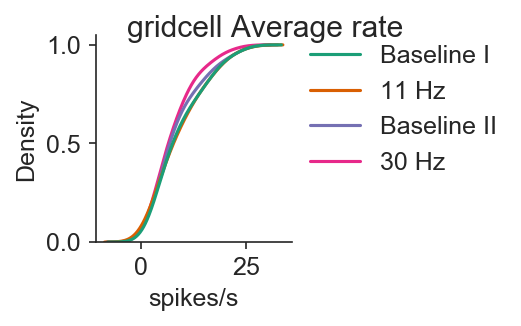

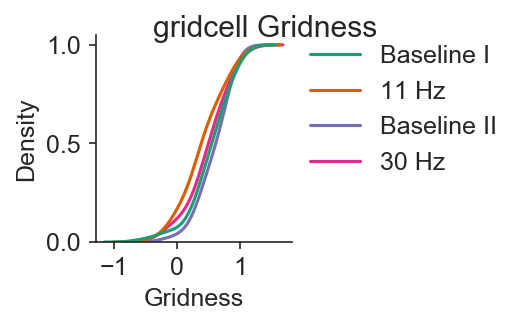

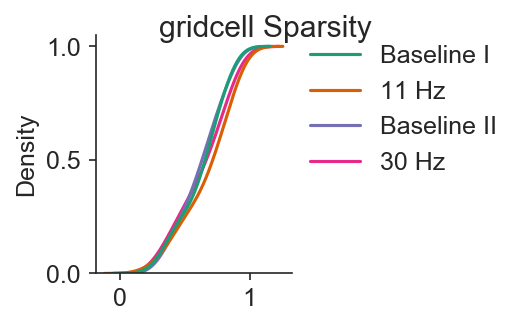

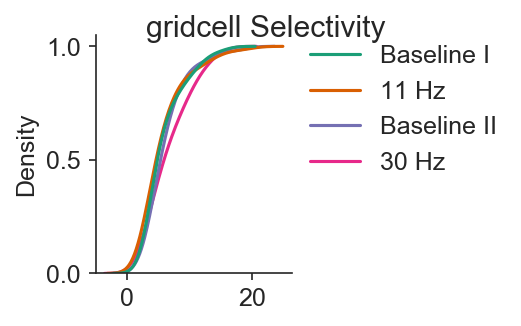

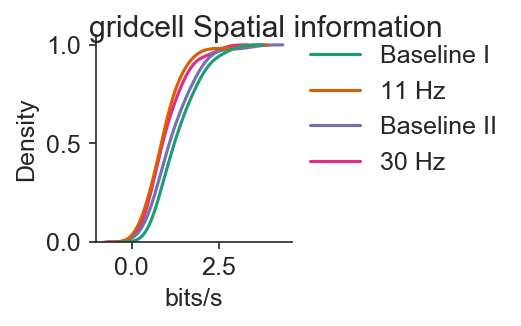

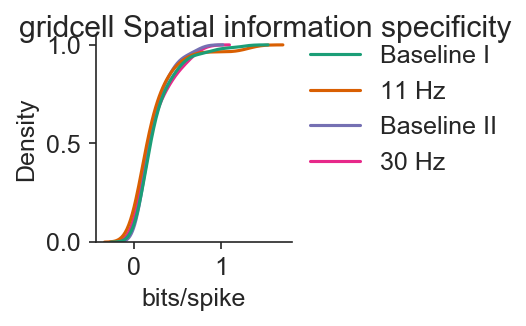

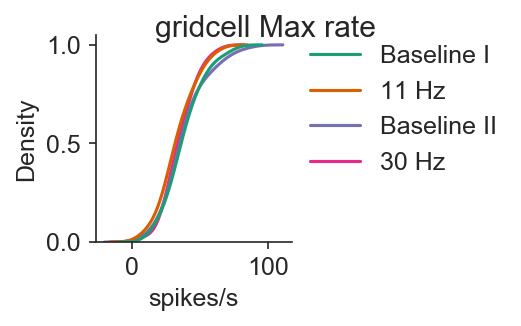

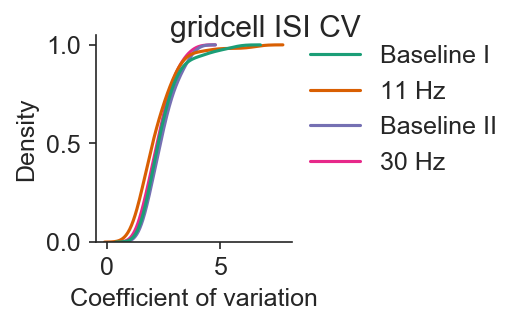

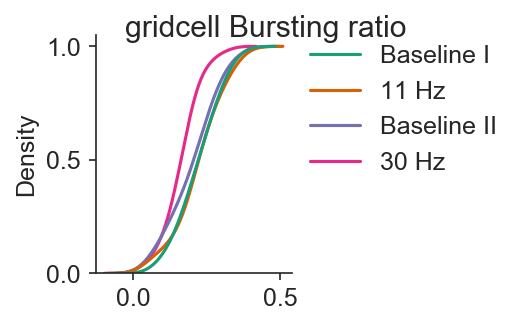

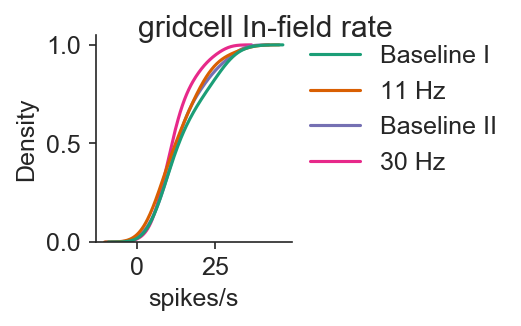

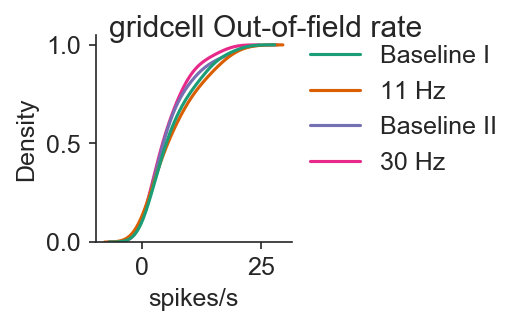

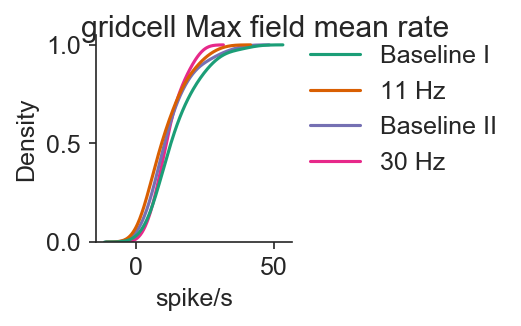

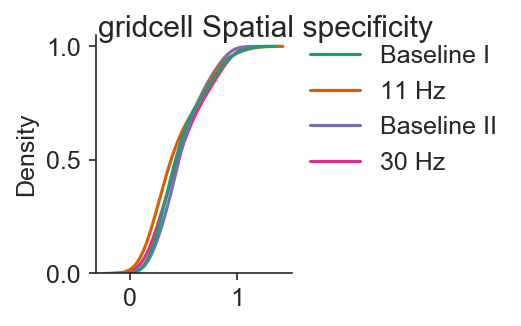

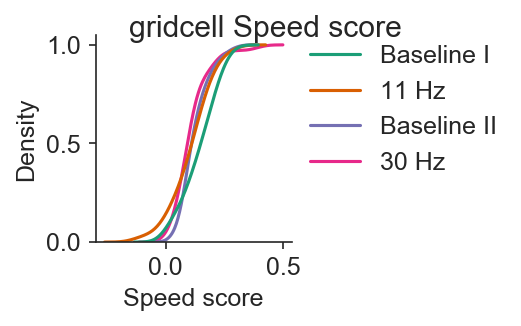

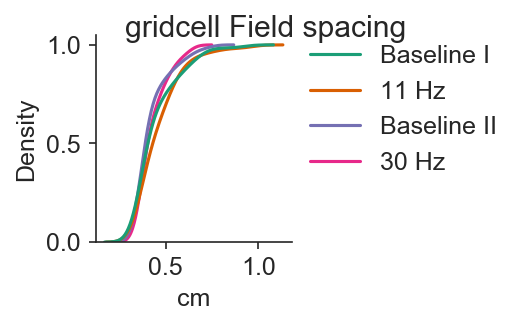

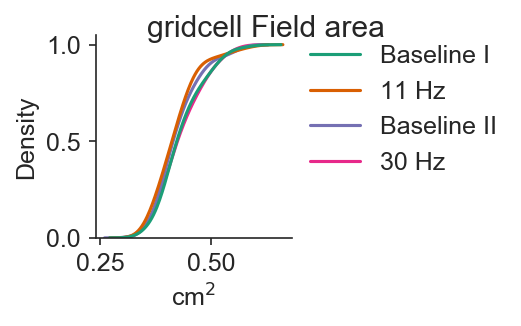

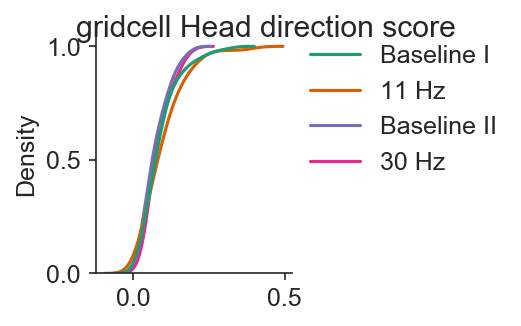

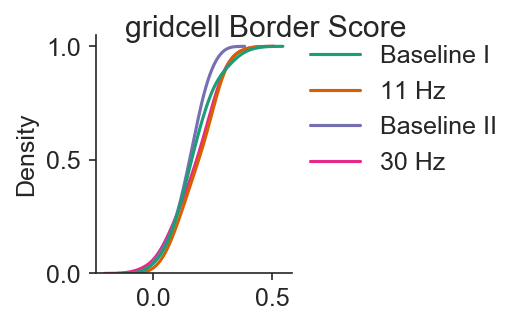

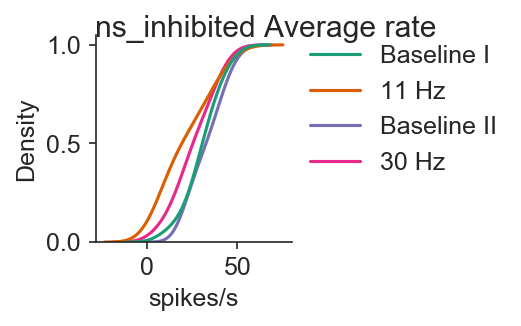

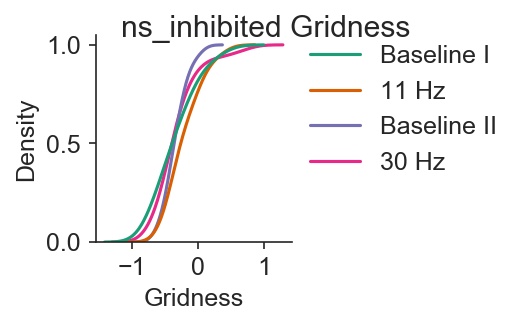

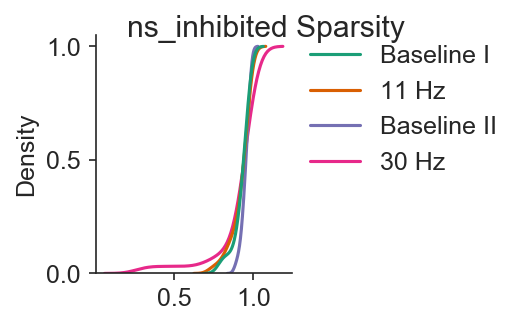

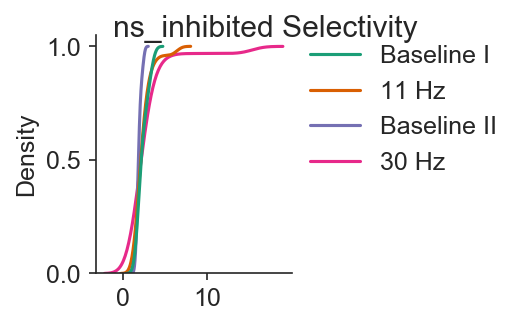

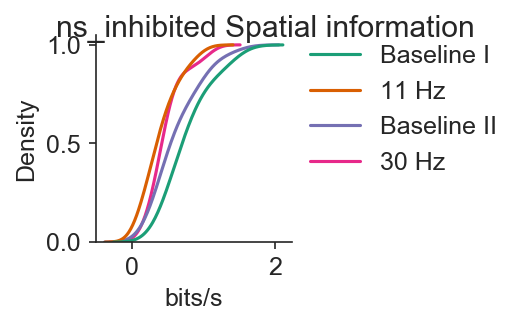

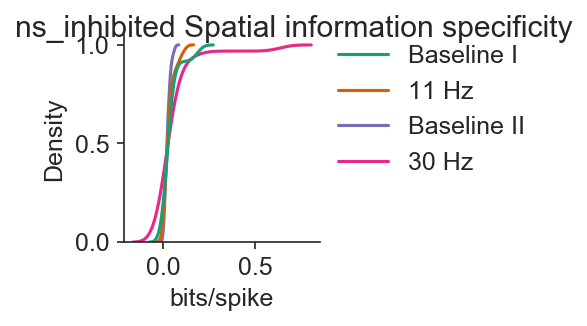

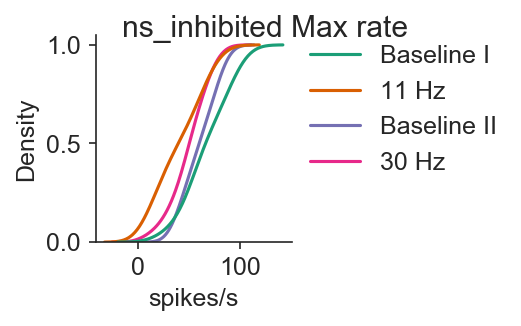

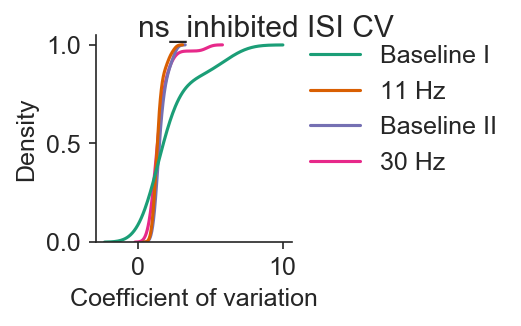

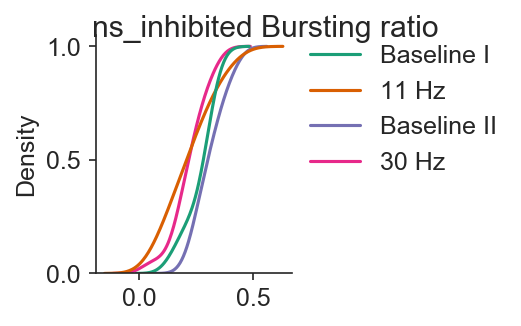

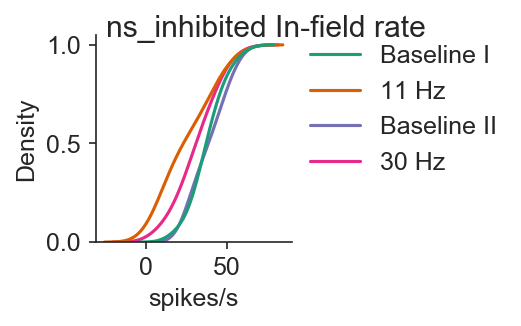

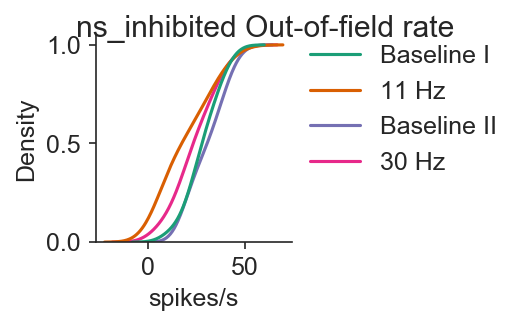

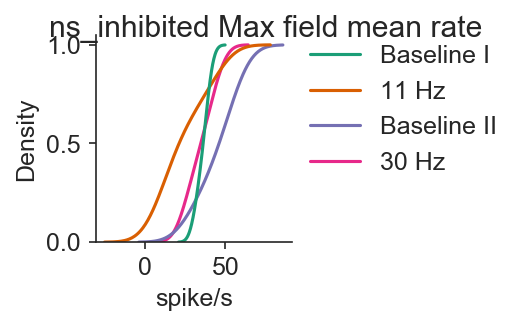

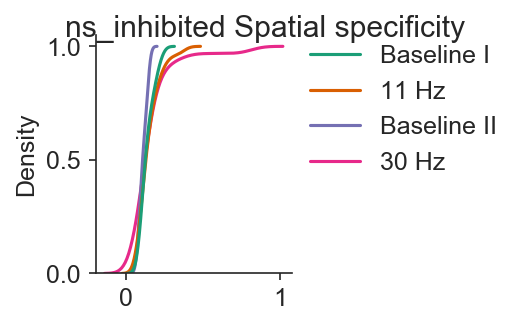

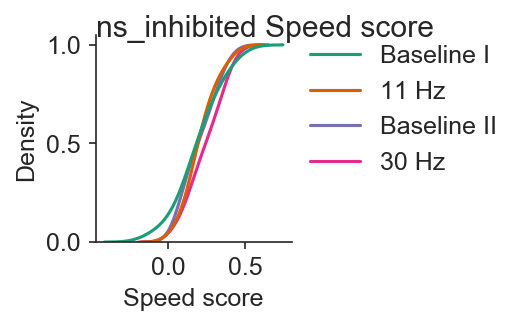

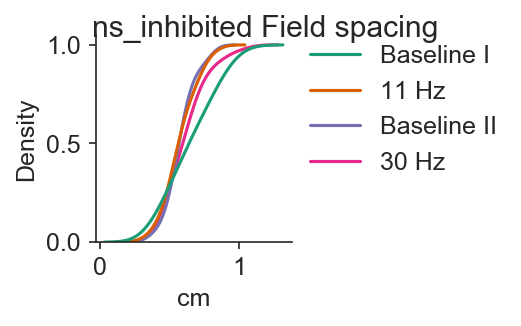

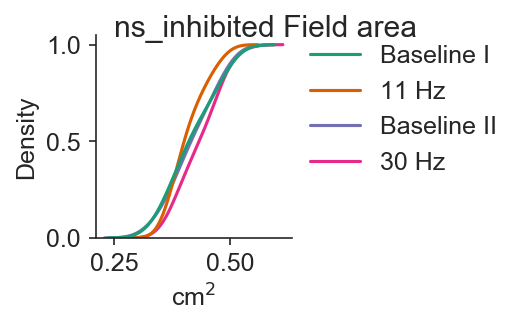

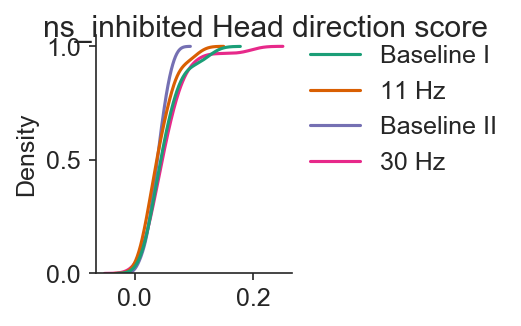

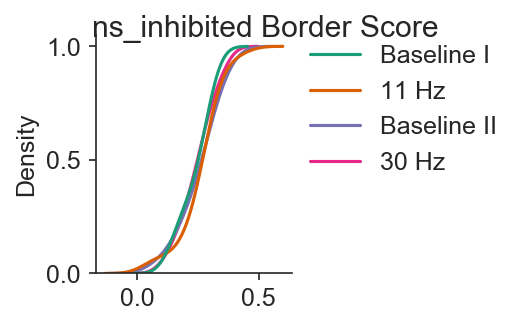

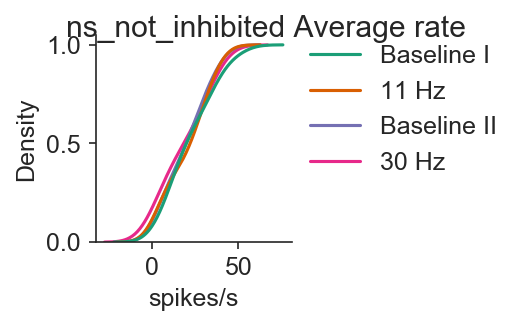

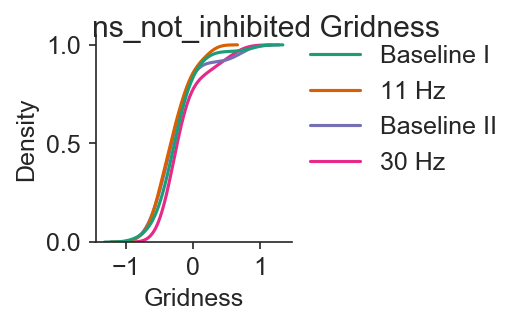

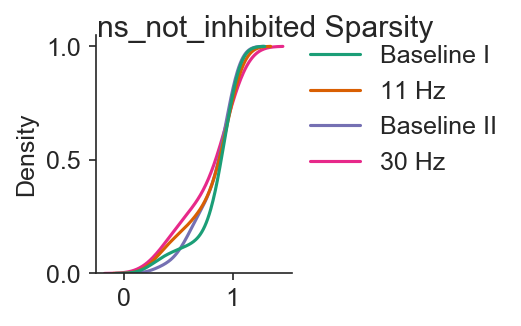

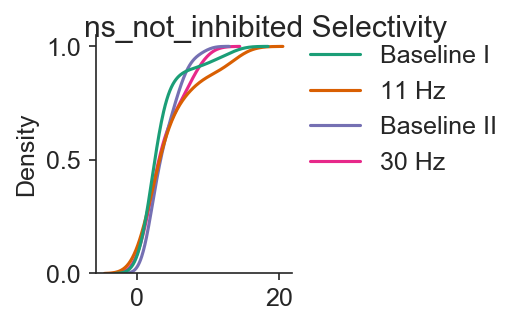

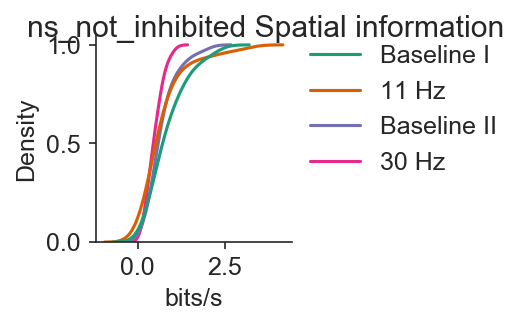

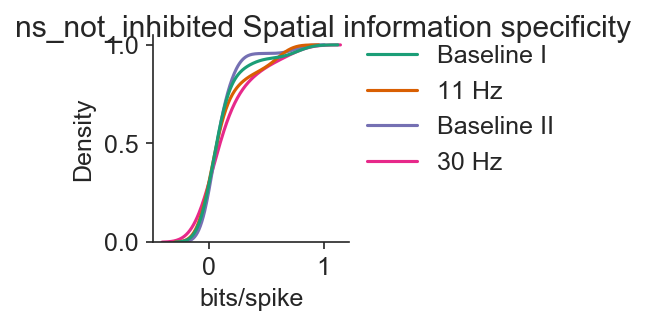

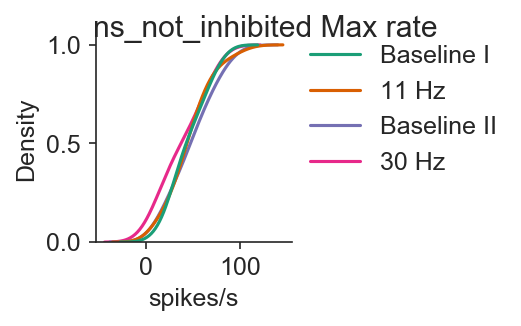

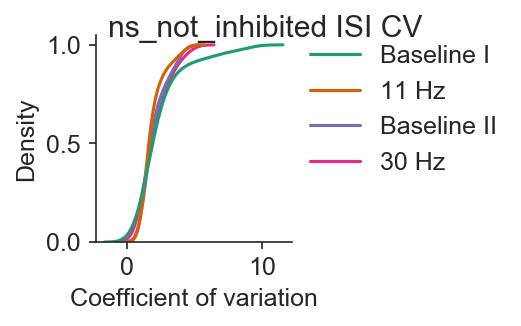

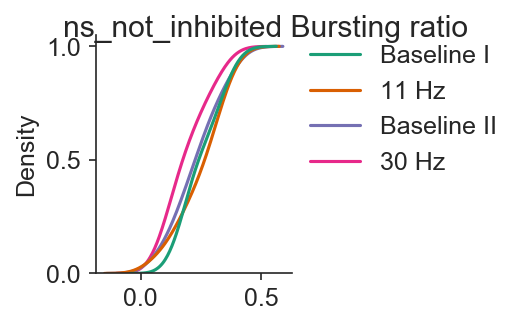

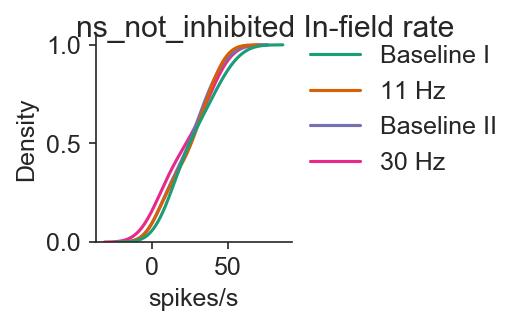

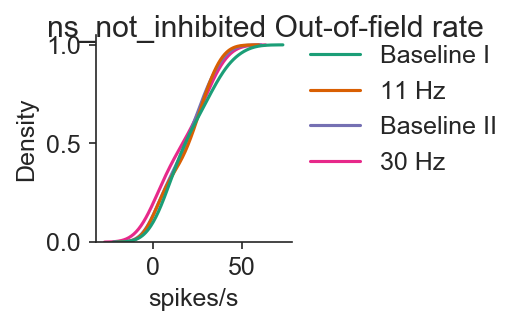

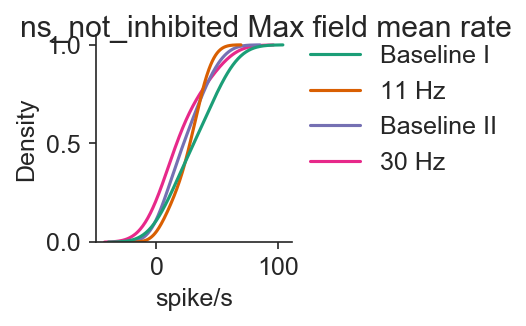

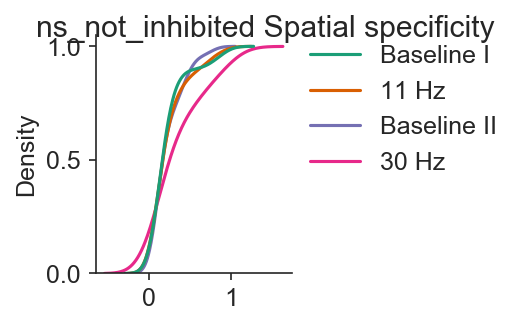

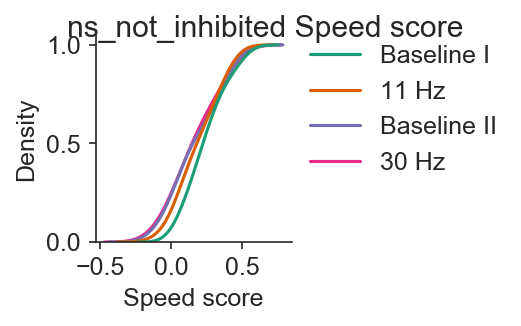

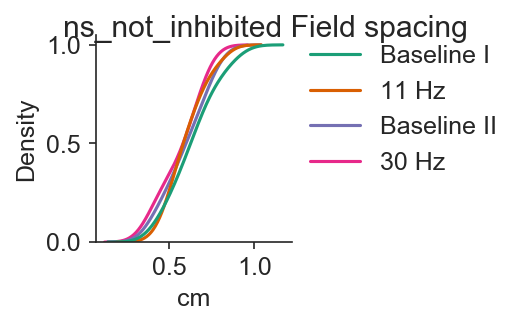

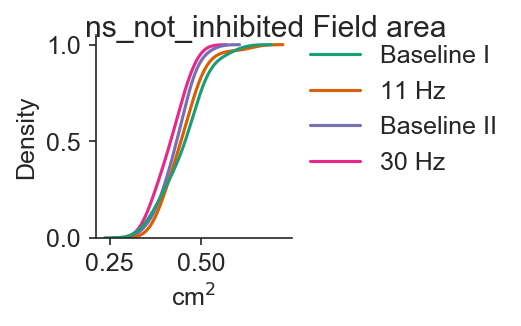

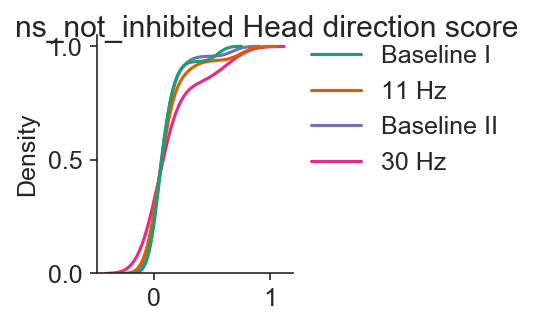

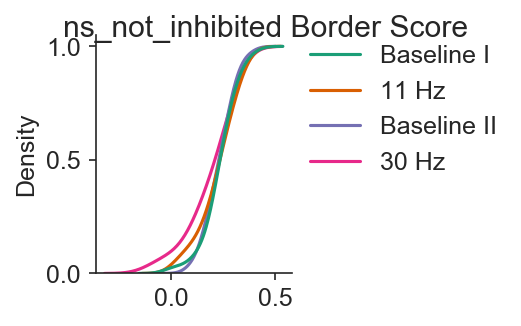

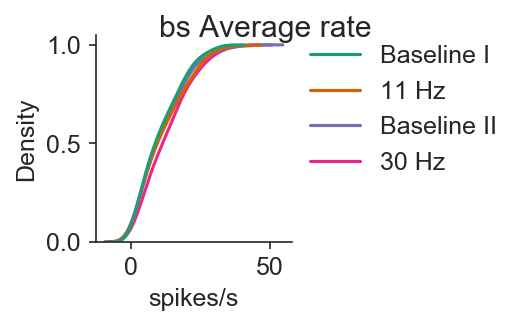

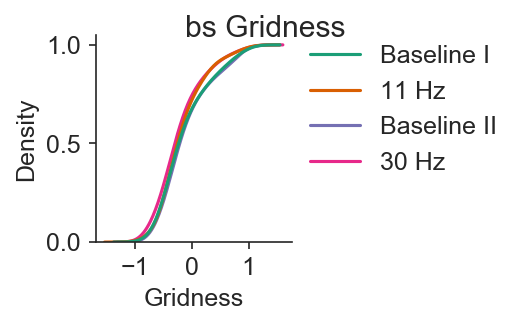

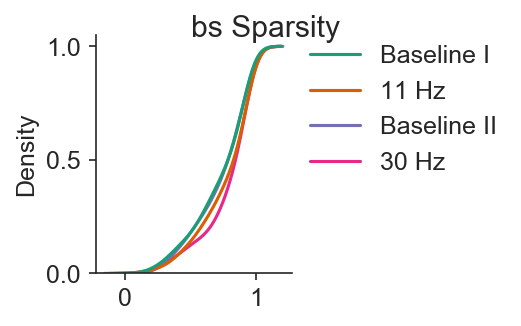

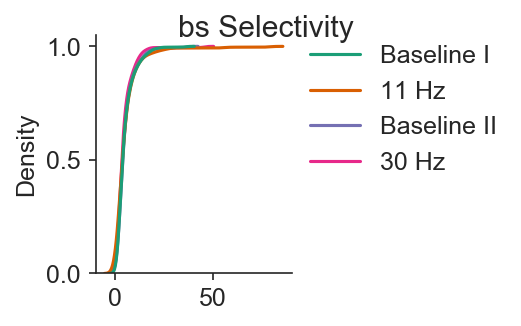

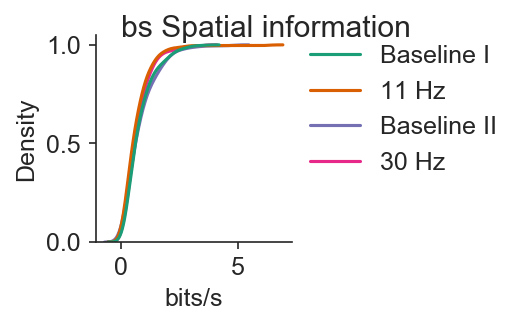

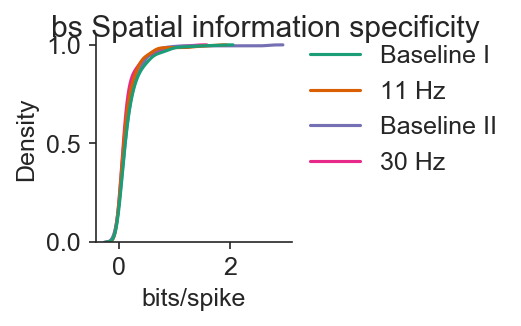

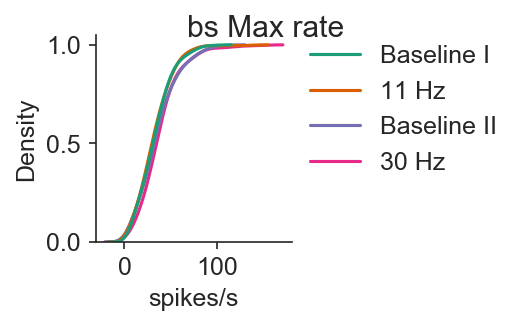

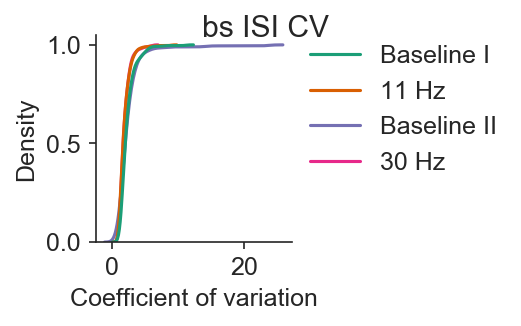

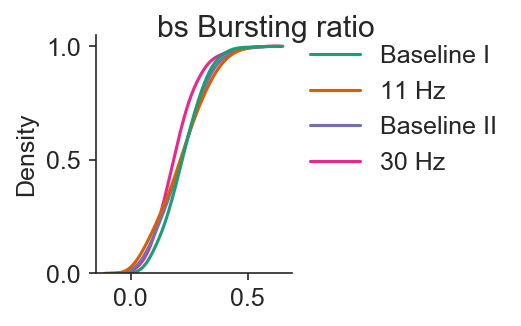

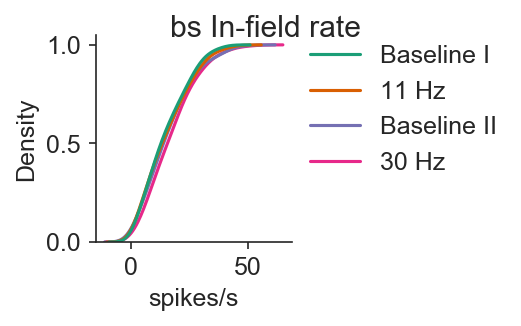

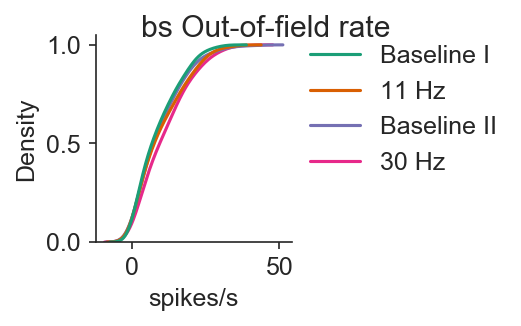

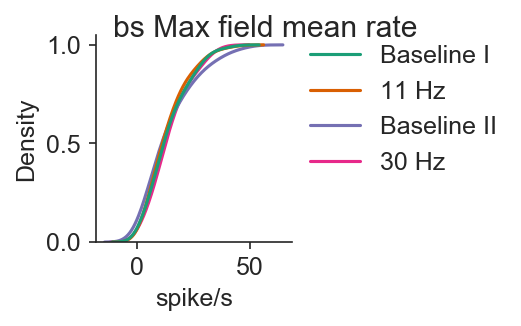

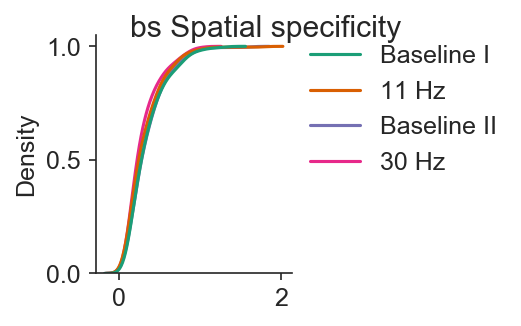

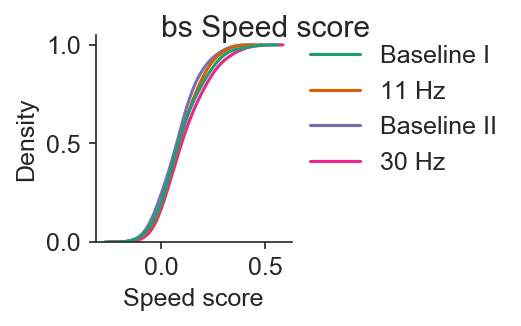

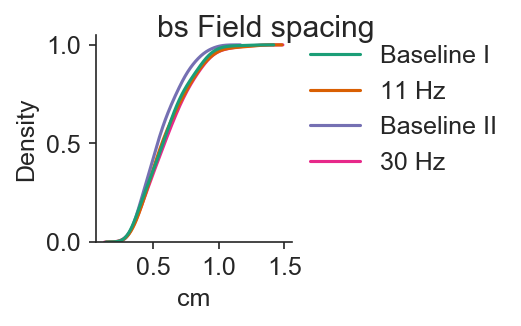

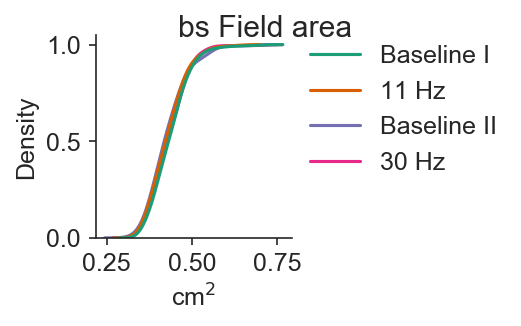

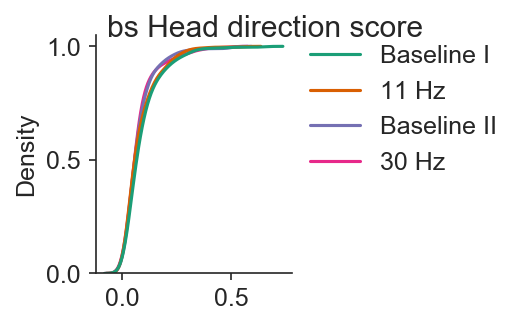

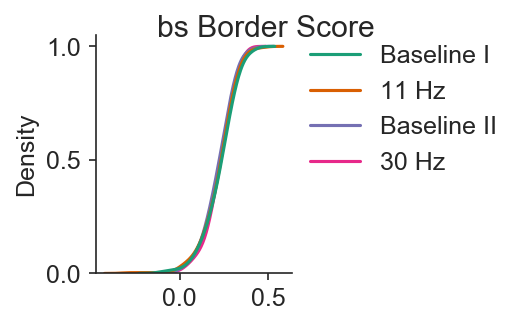

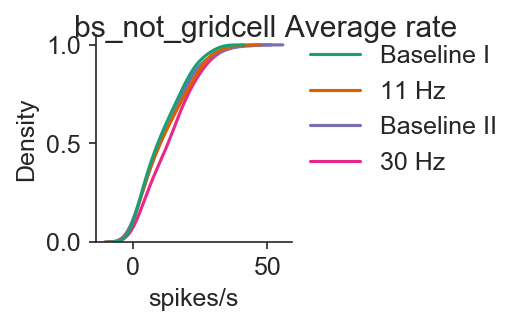

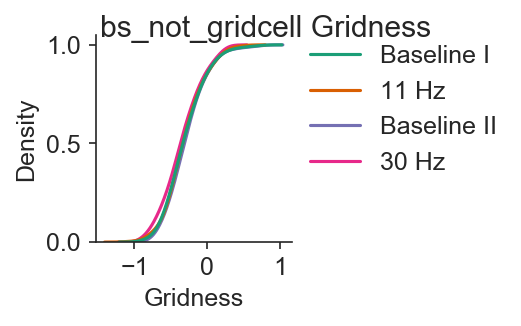

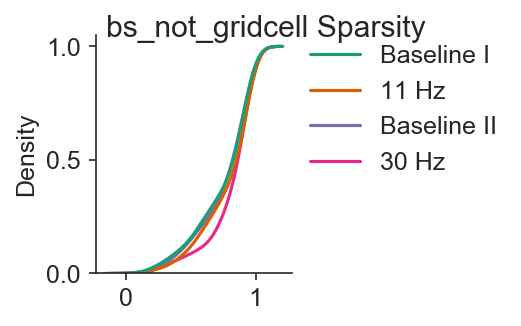

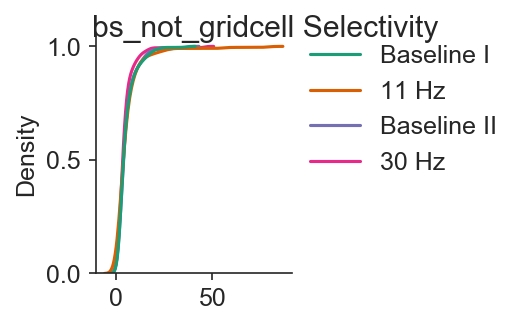

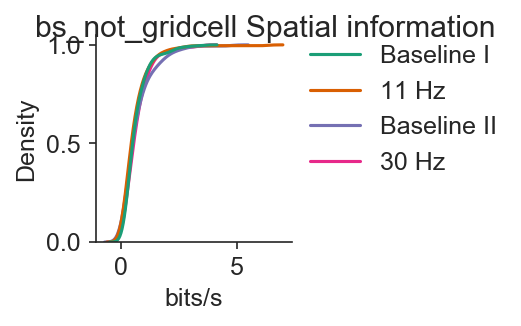

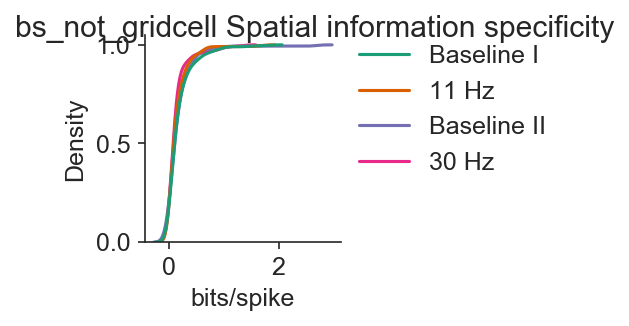

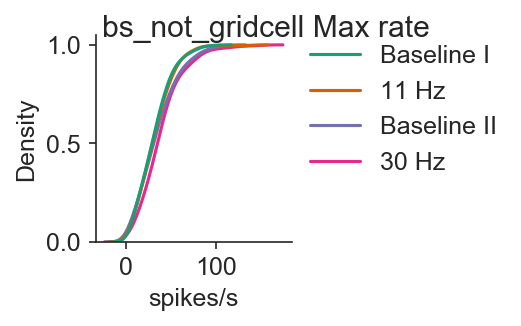

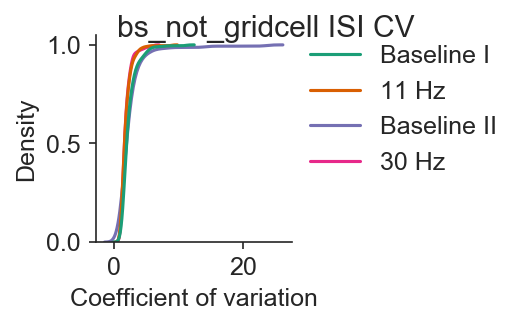

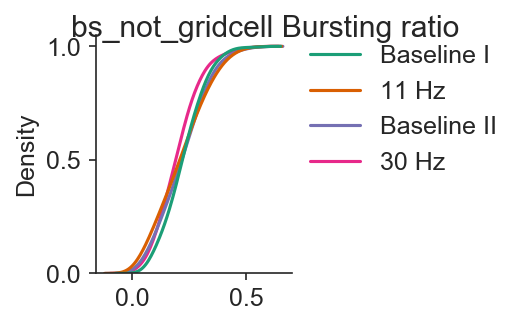

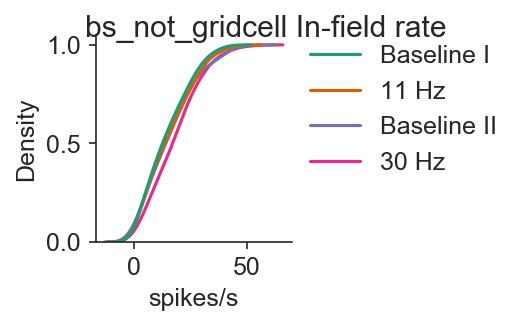

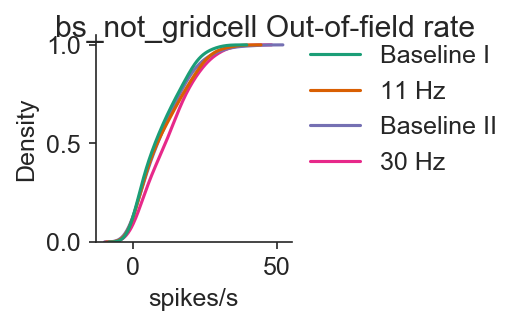

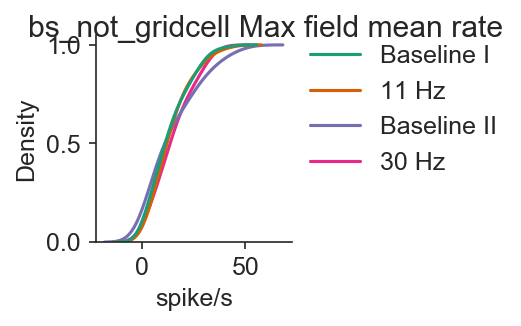

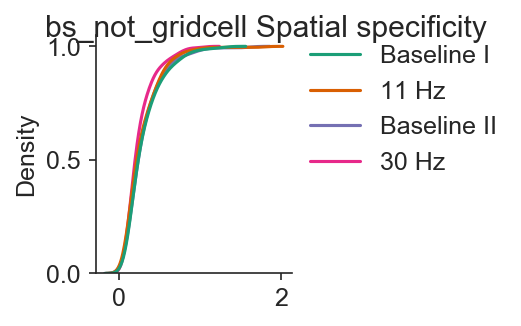

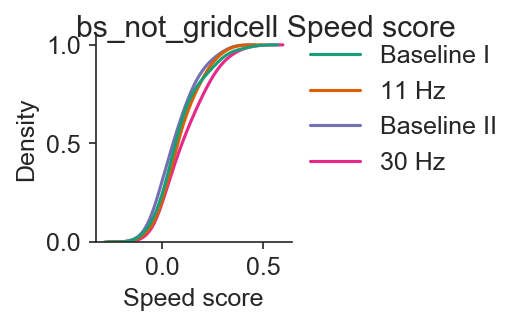

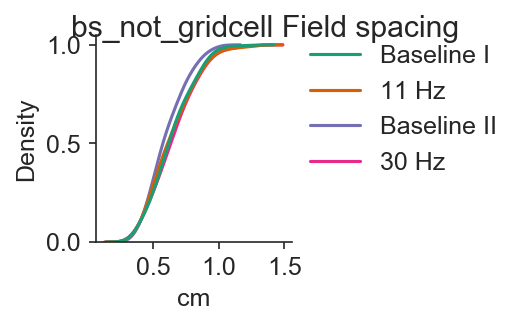

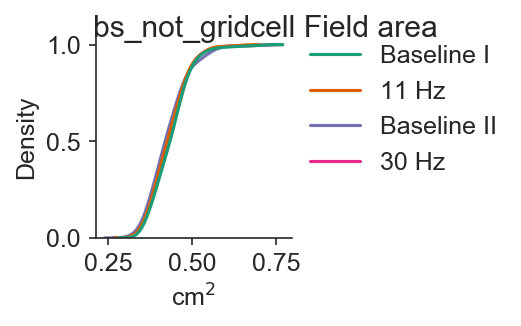

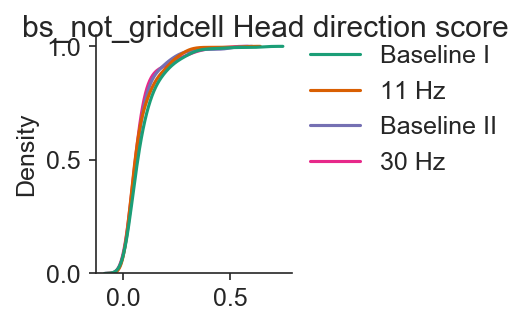

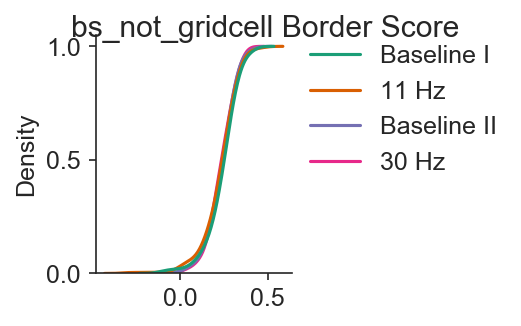

In [17]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        if key not in title_xlabel:
            continue
        fig = plt.figure()
        plt.suptitle(cell_type + ' ' + title_xlabel[key][0])
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=result.loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(title_xlabel[key][1])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        savefig(output_path / "figures" / f'{cell_type}_{key}')

# Violinplot

In [18]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7*3, 3), 
    'figure.dpi': 150
})

# Information rate

In [19]:
def violinplot(df, labels, colors, statistics=None):
    data = np.array([df.loc[:,label].dropna().to_numpy() for label in labels])
    pos = np.array([i * 0.6 for i in range(len(data))])
    labels = np.array(labels)
#     print(pos)
    violins = plt.violinplot(data, pos, showmedians=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, labels, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

           
    if statistics is not None:
        tests = [[0,1], [2,3], [0,2]]
        ds = [0,0,1]
        for test, d in zip(tests, ds):
            pvalue = statistics.loc[' - '.join(labels[test])]
            # significance
            if pvalue < 0.0001:
                significance = "****"
            elif pvalue < 0.001:
                significance = "***"
            elif pvalue < 0.01:
                significance = "**"
            elif pvalue < 0.05:
                significance = "*"
            else:
                significance = "ns"

            x1, x2 = pos[test]
            data_max = np.max([a.max() for a in data[test]])
            data_min = np.min([a.min() for a in data[test]])
            y = (data_max * 1.05)
            h = 0.025 * (data_max - data_min)
            d_ =  d * 0.15 * (data_max - data_min)
            plt.plot([x1, x1, x2, x2], np.array([y - h, y, y, y - h]) + d_, c='k')
            plt.text((x1 + x2) / 2, y + h + d_, significance, ha='center', va='bottom')
           
            
        
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)

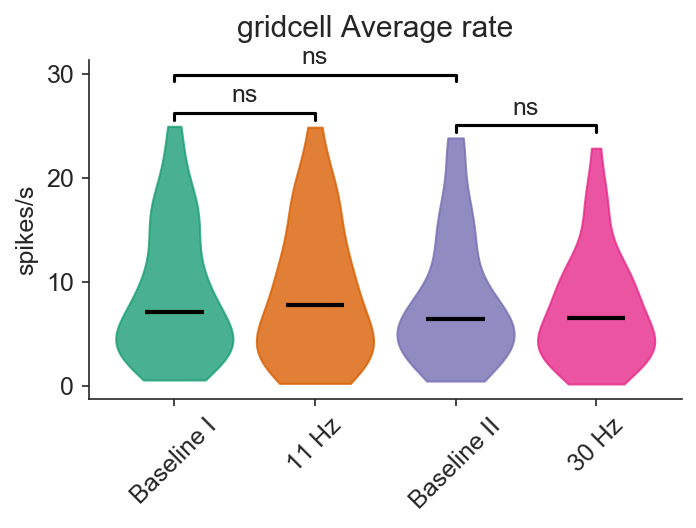

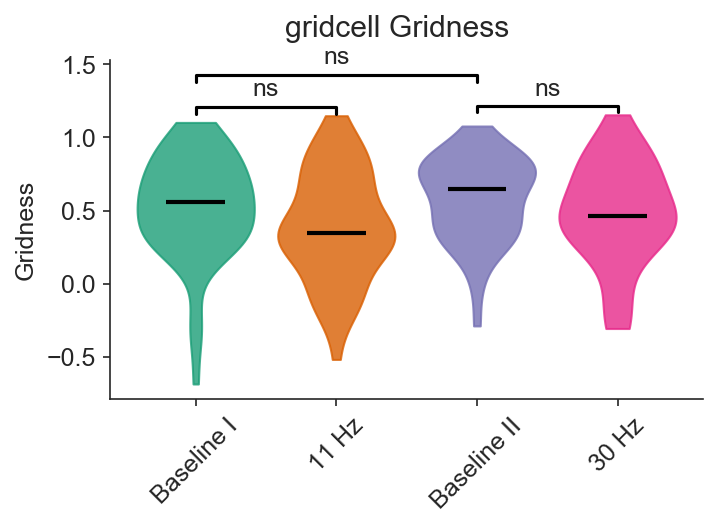

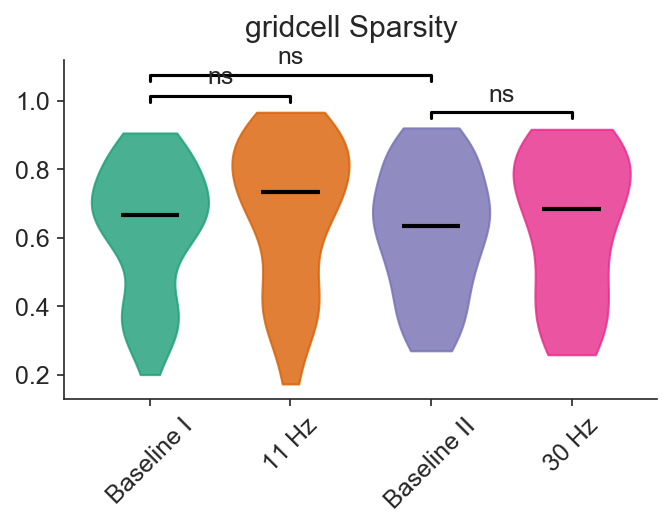

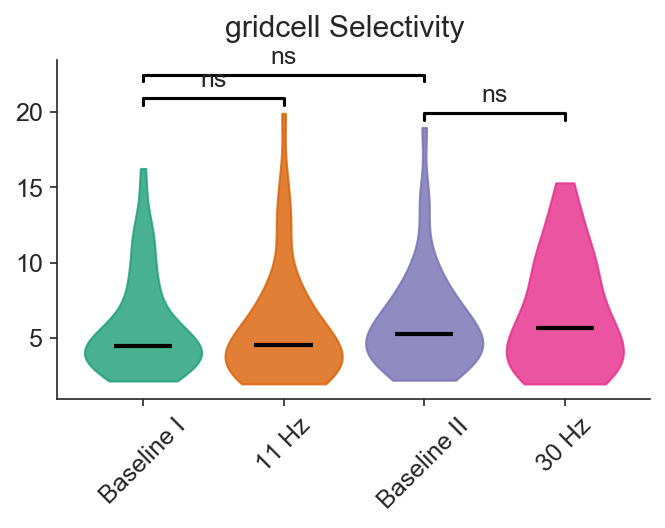

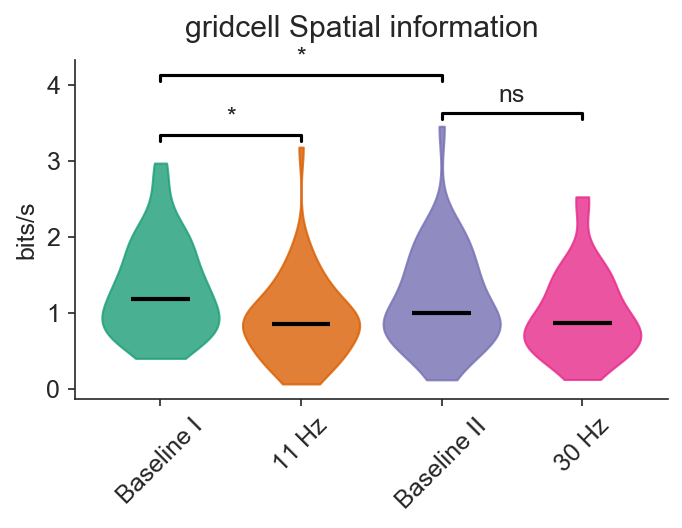

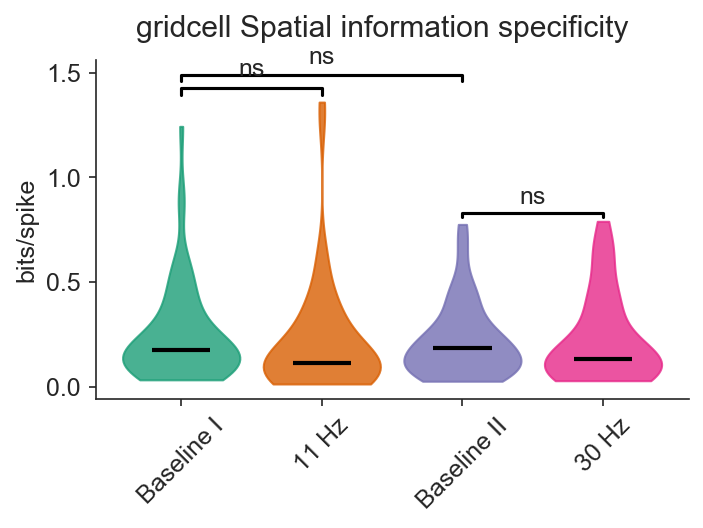

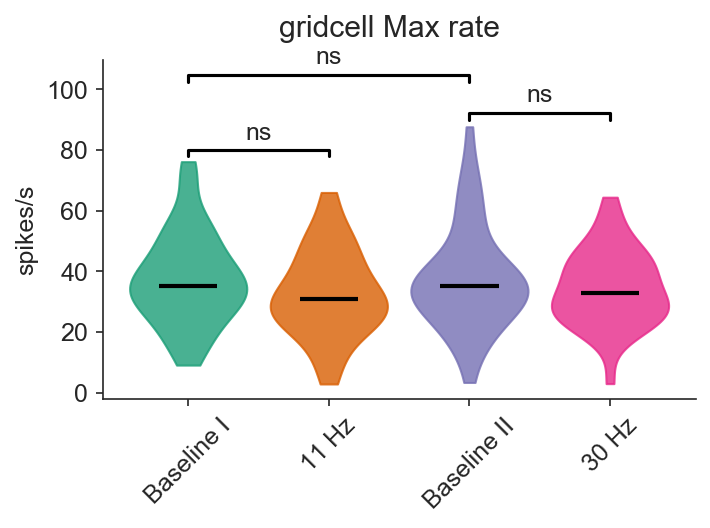

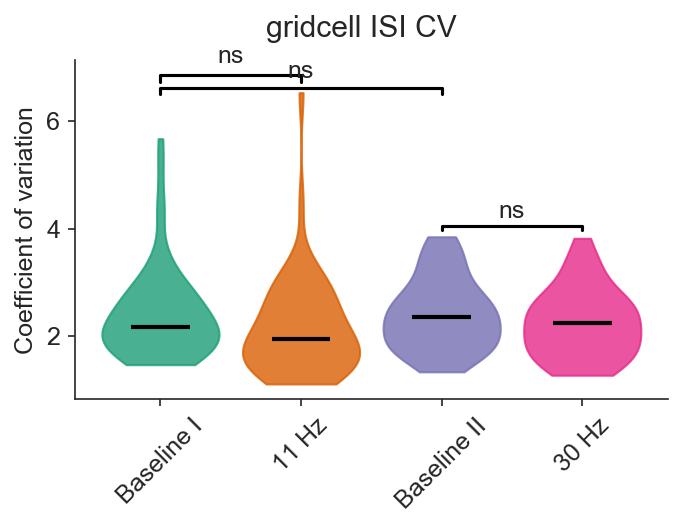

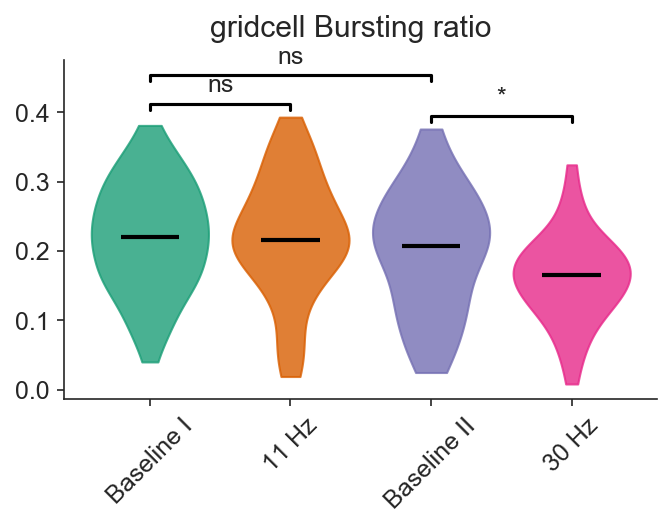

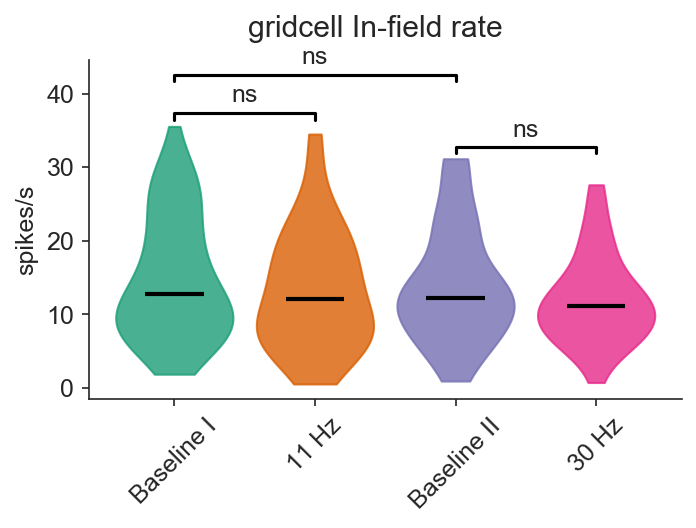

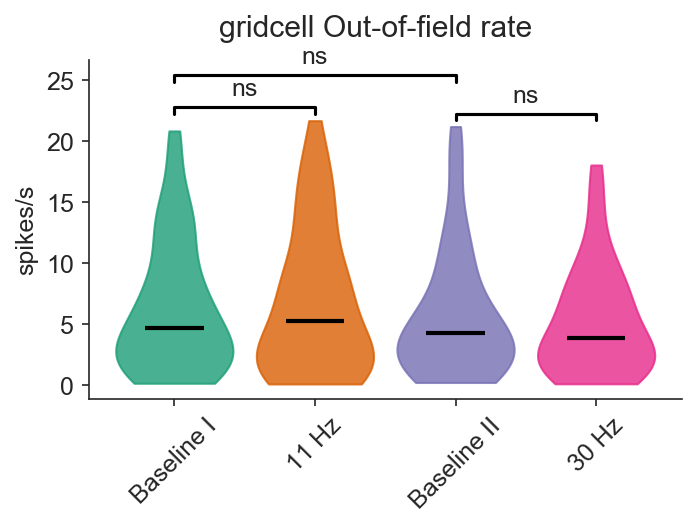

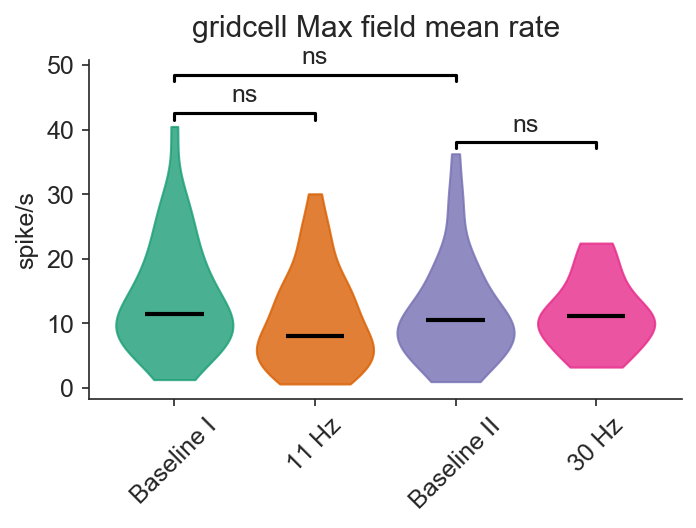

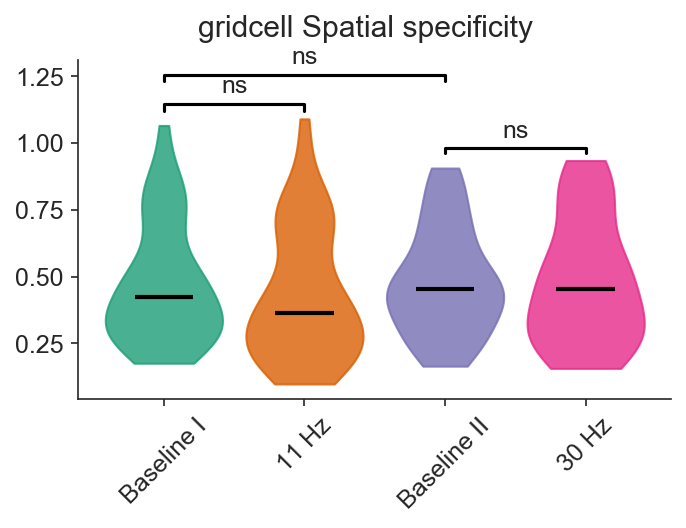

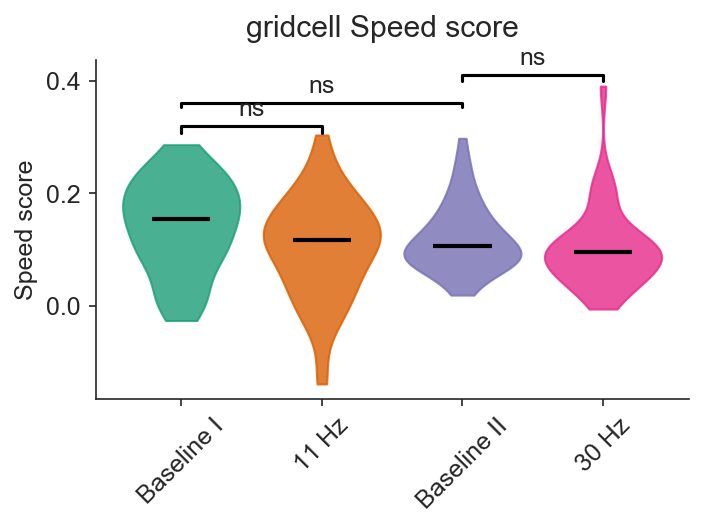

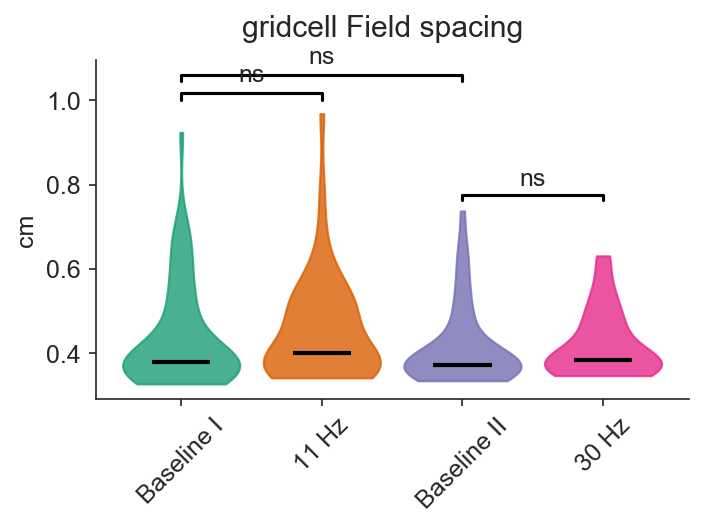

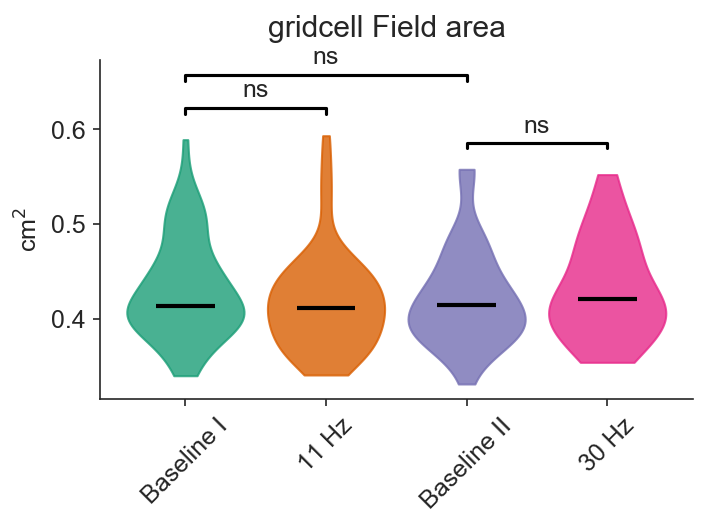

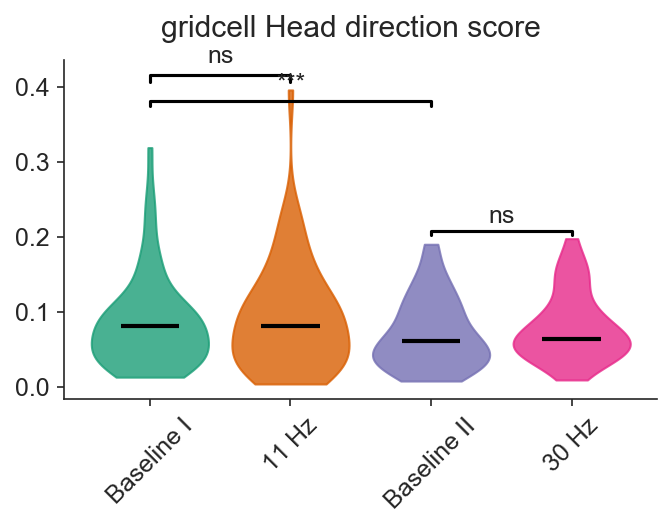

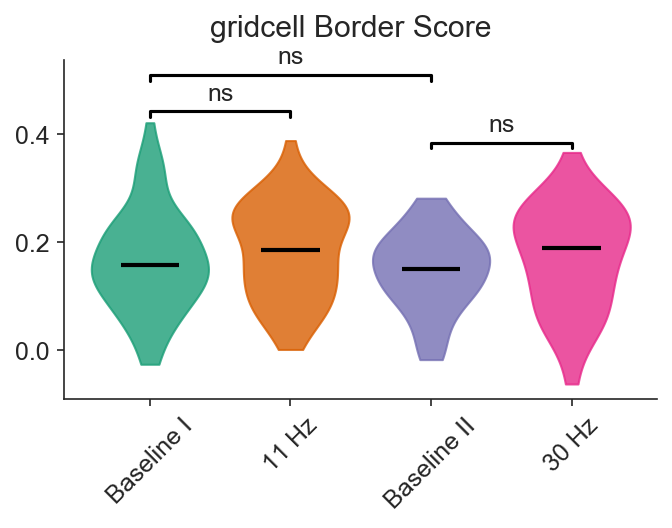

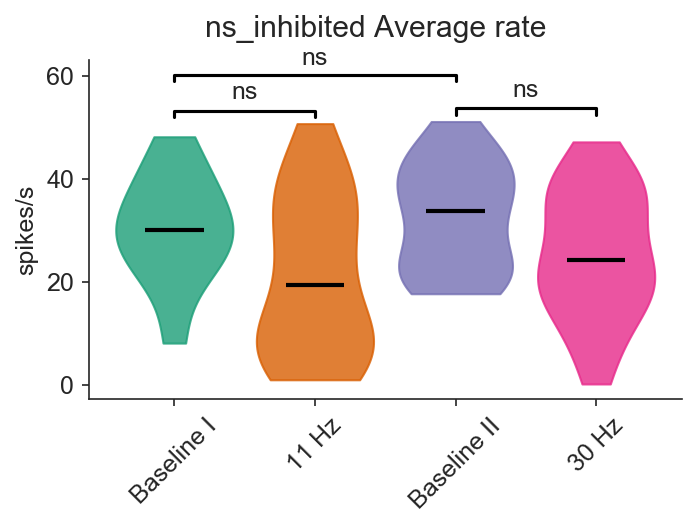

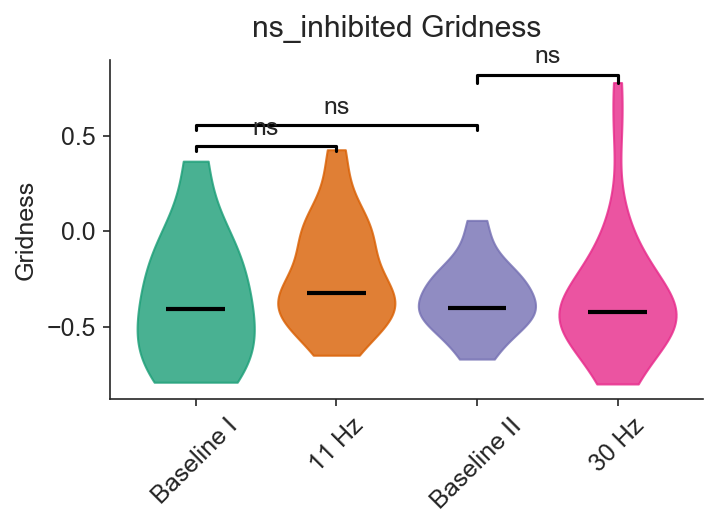

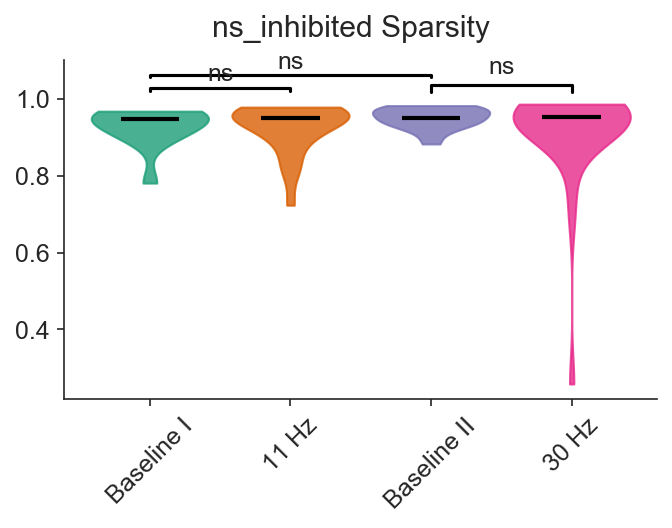

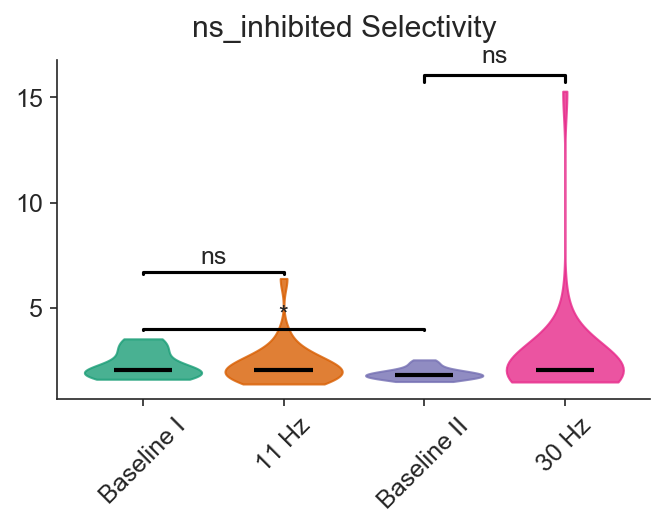

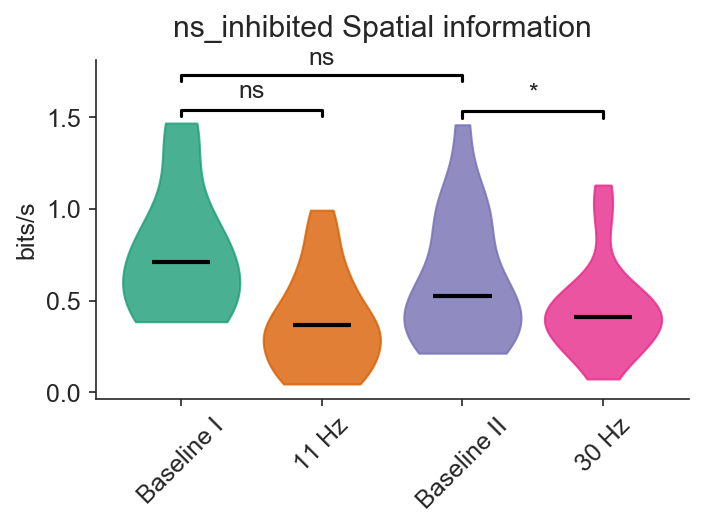

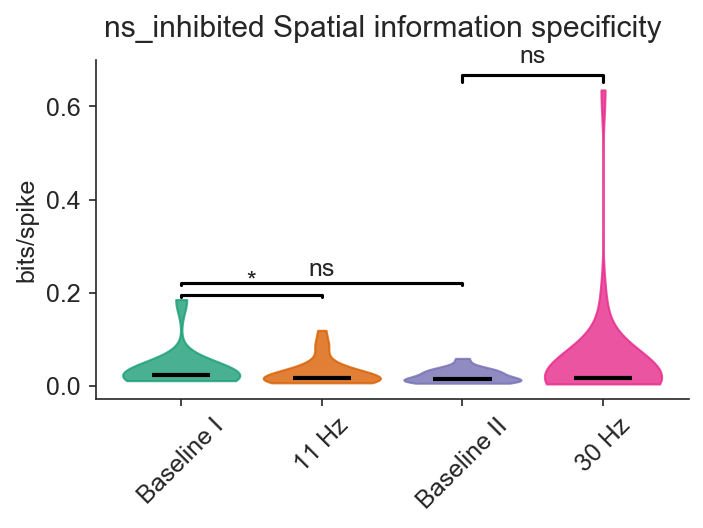

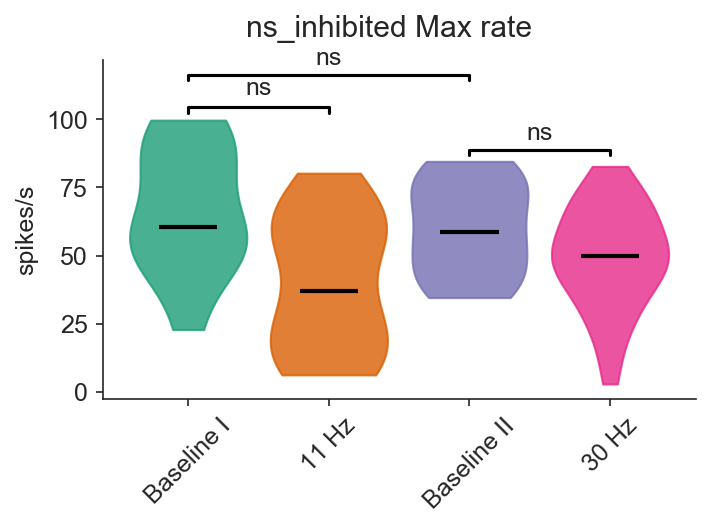

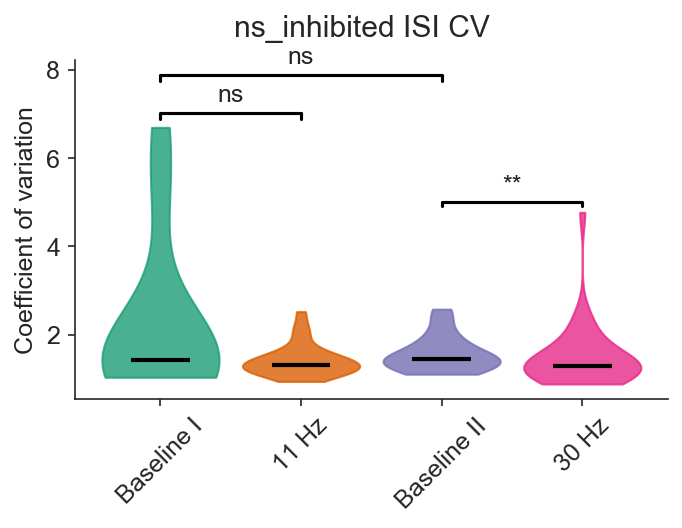

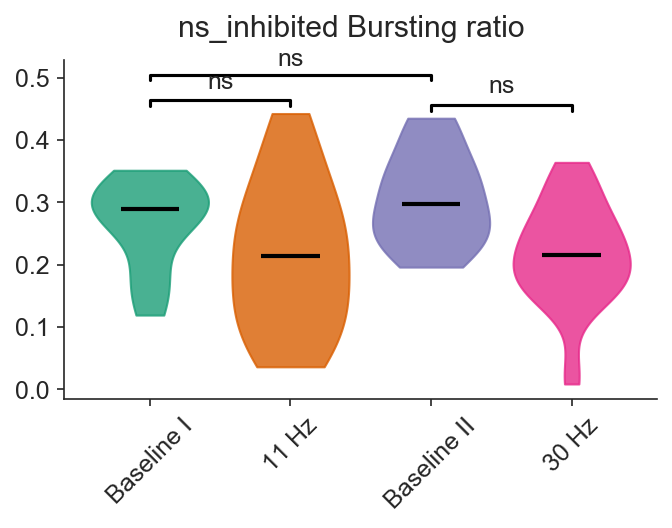

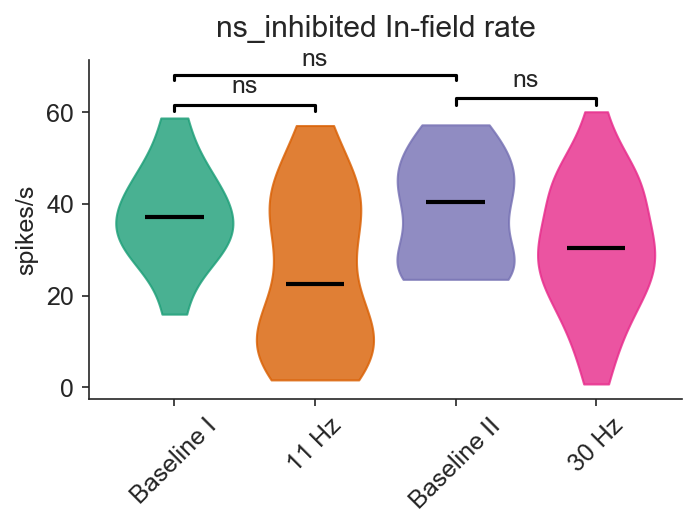

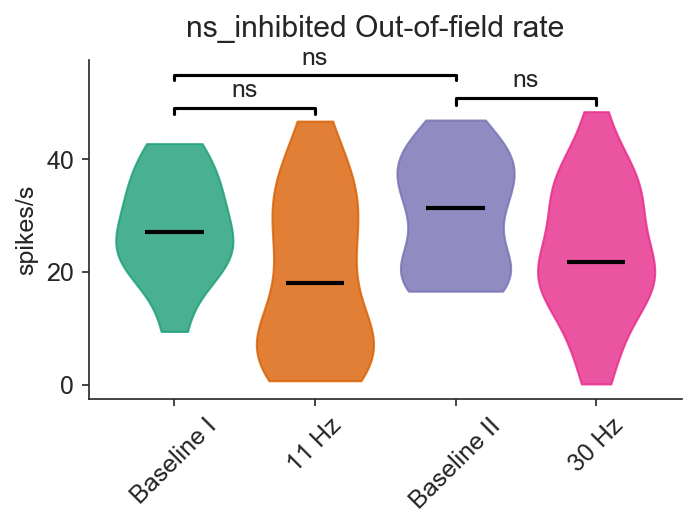

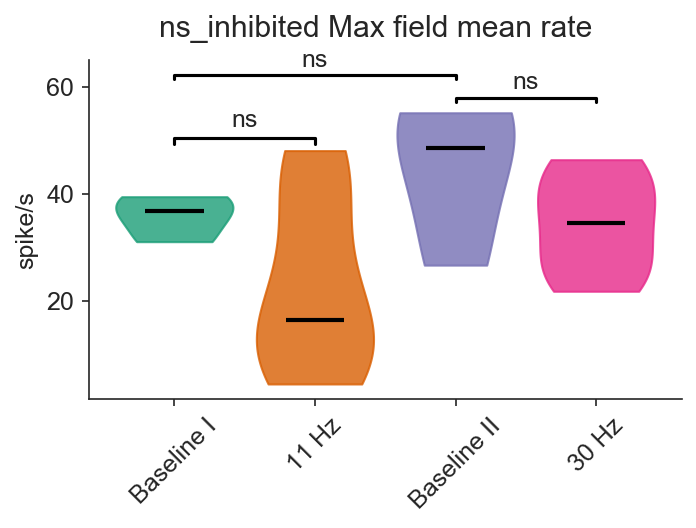

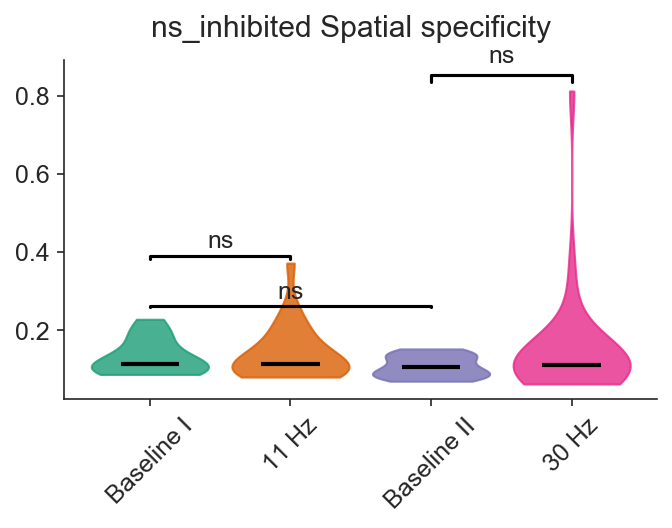

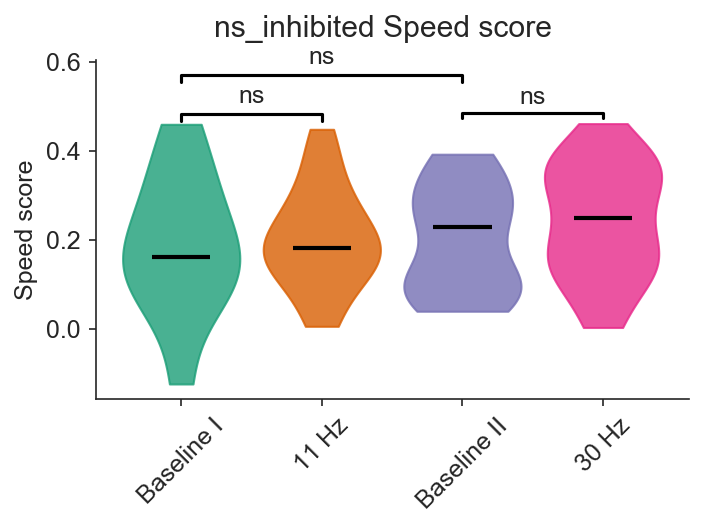

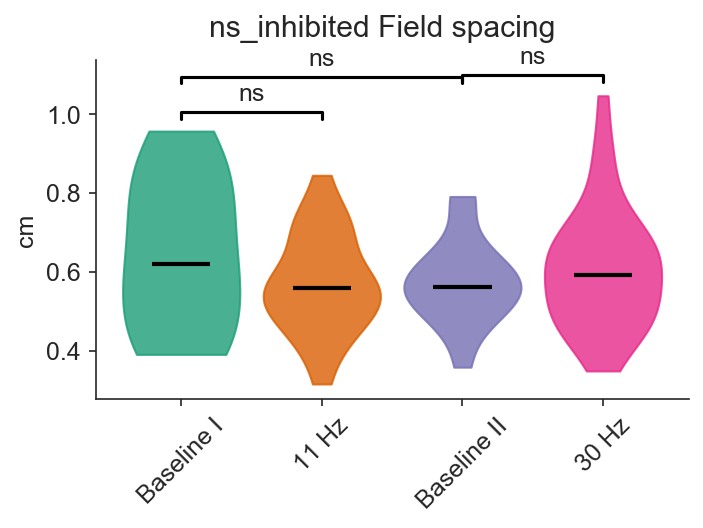

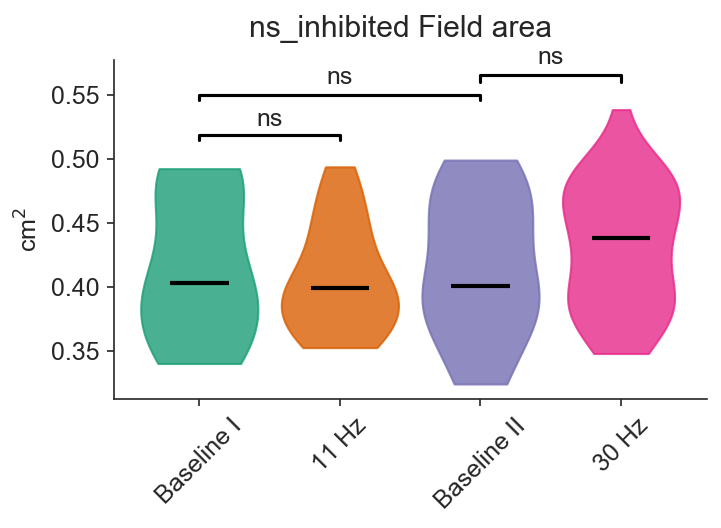

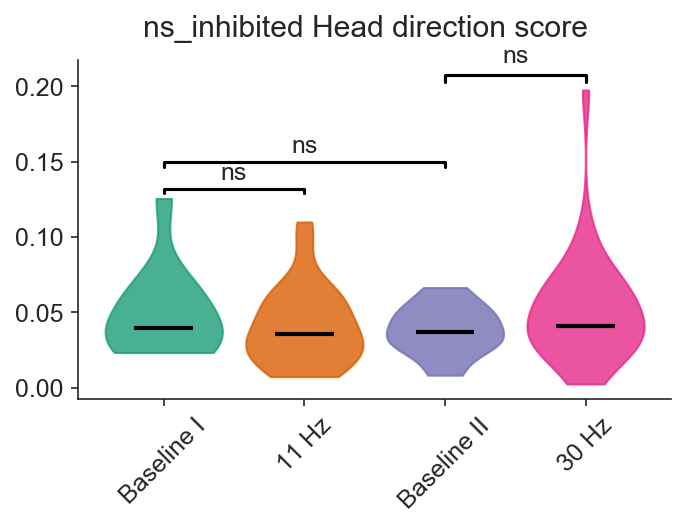

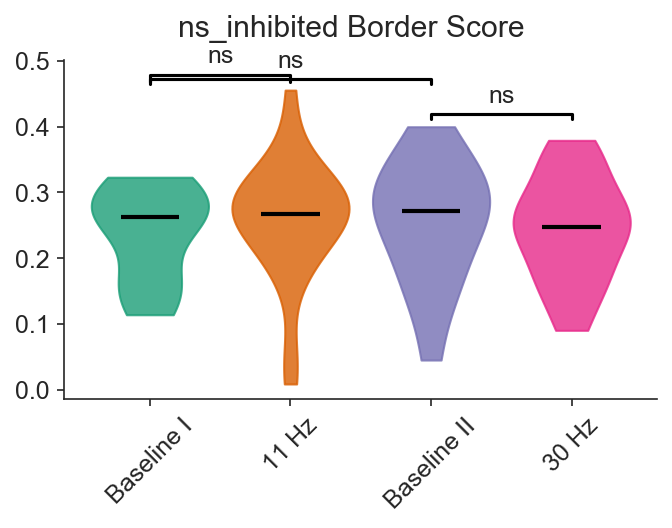

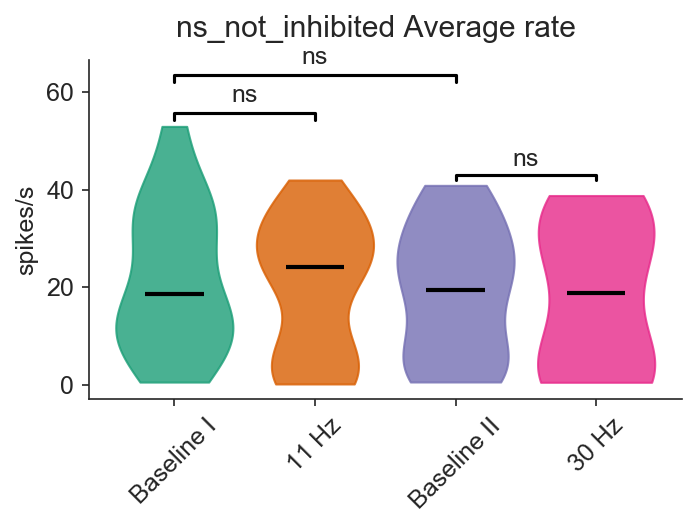

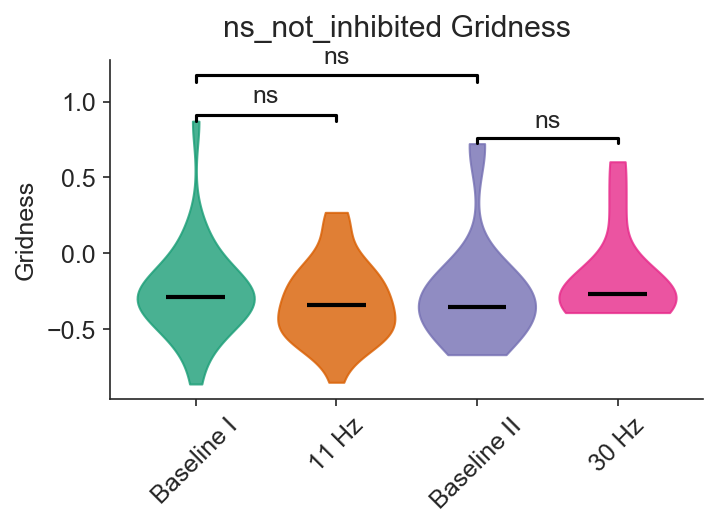

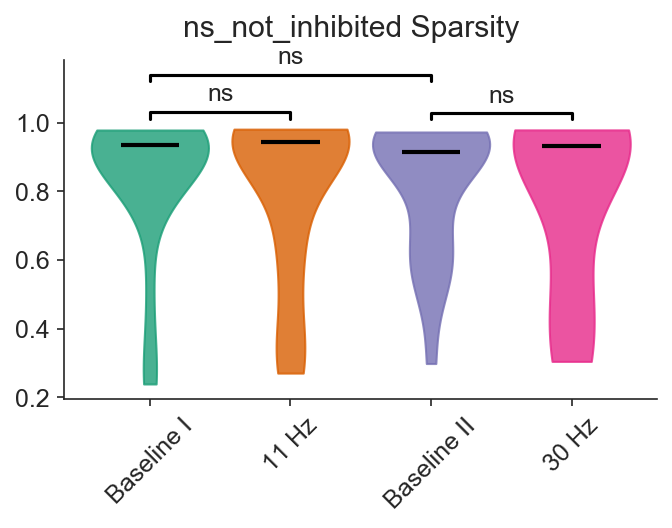

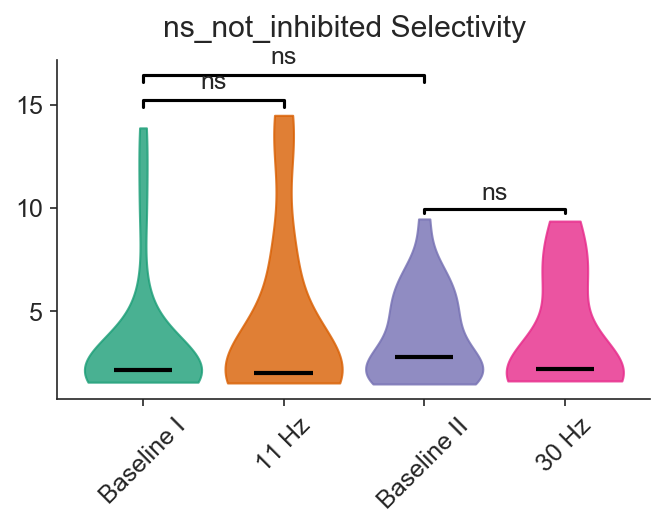

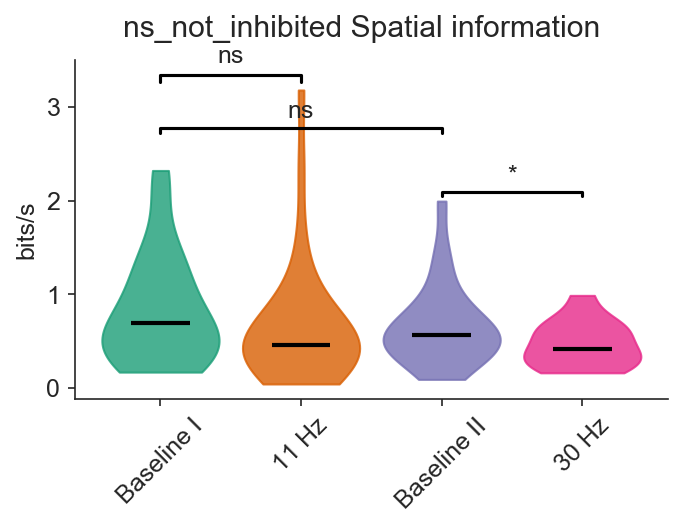

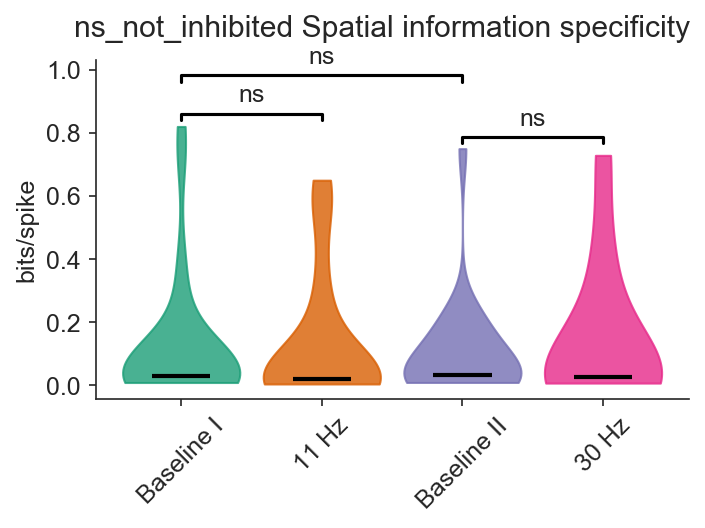

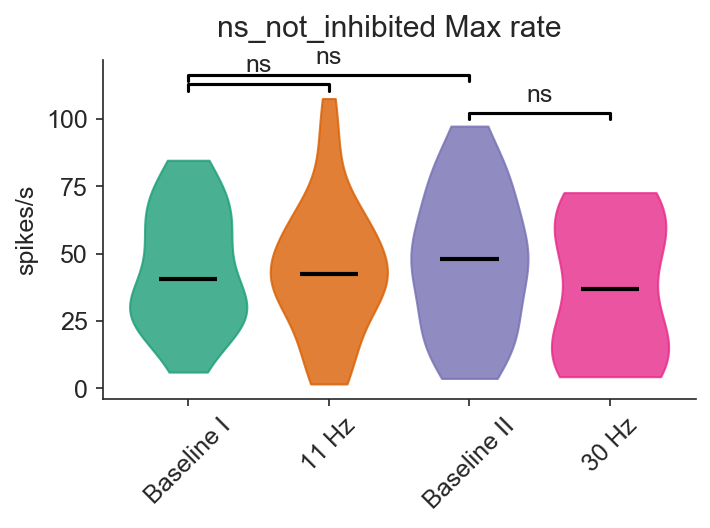

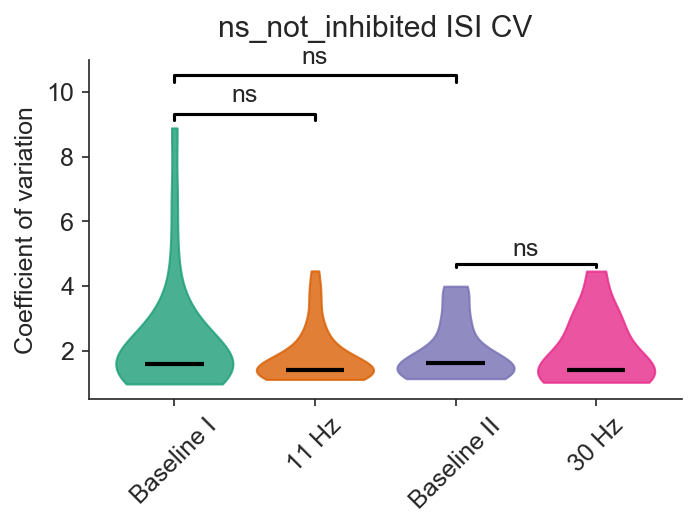

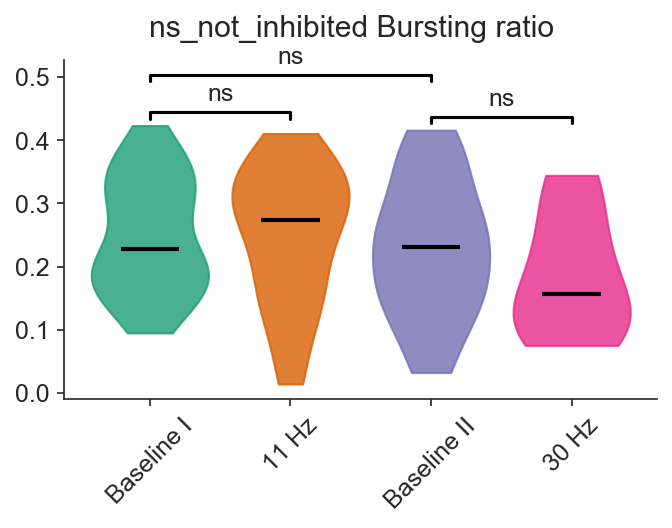

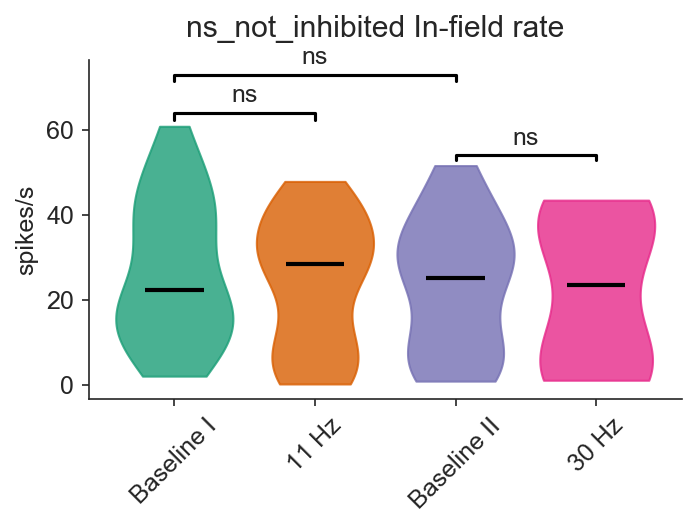

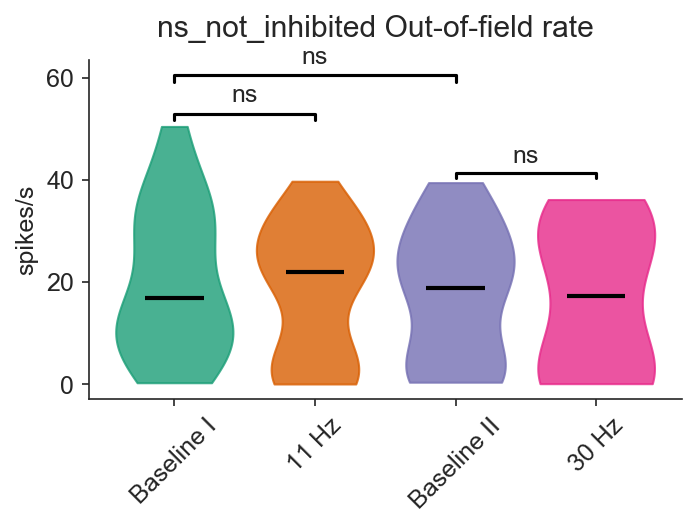

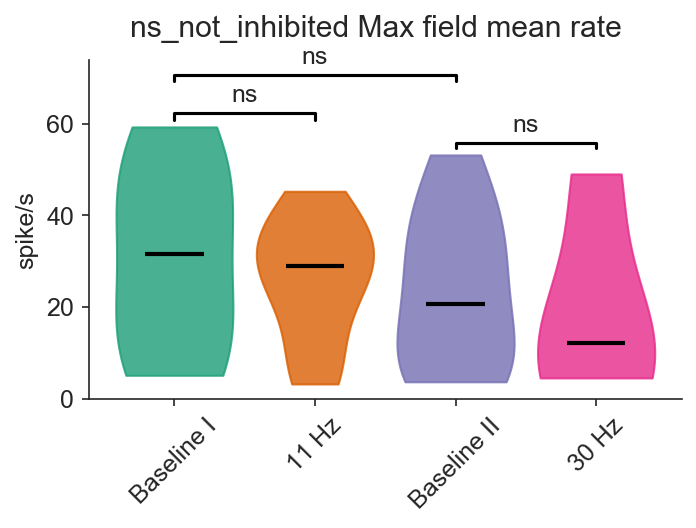

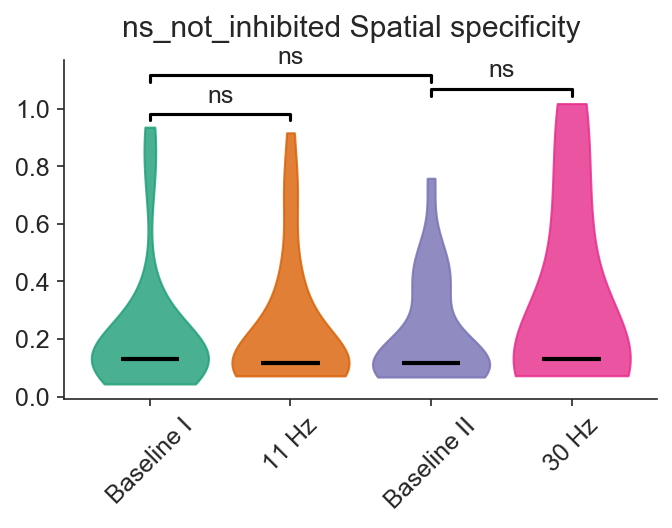

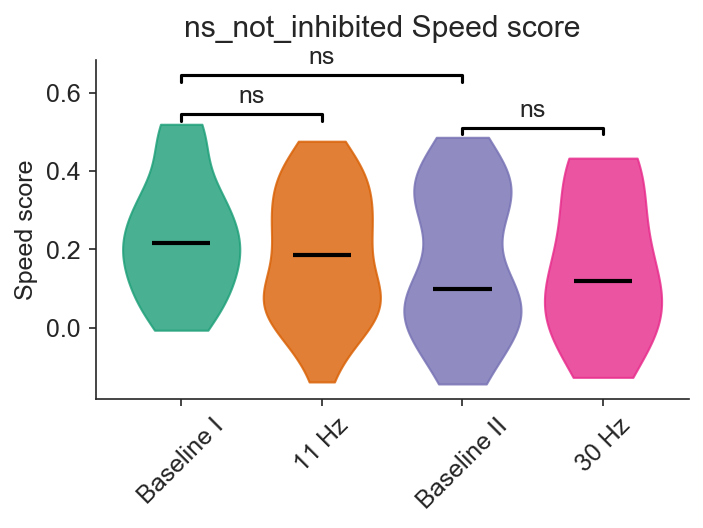

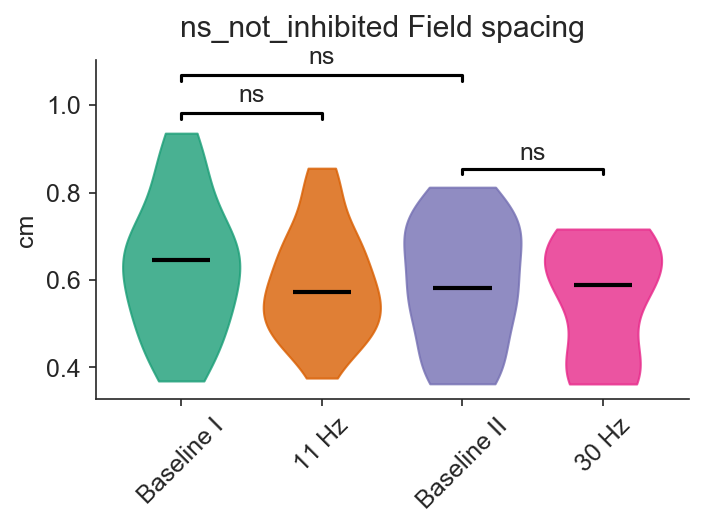

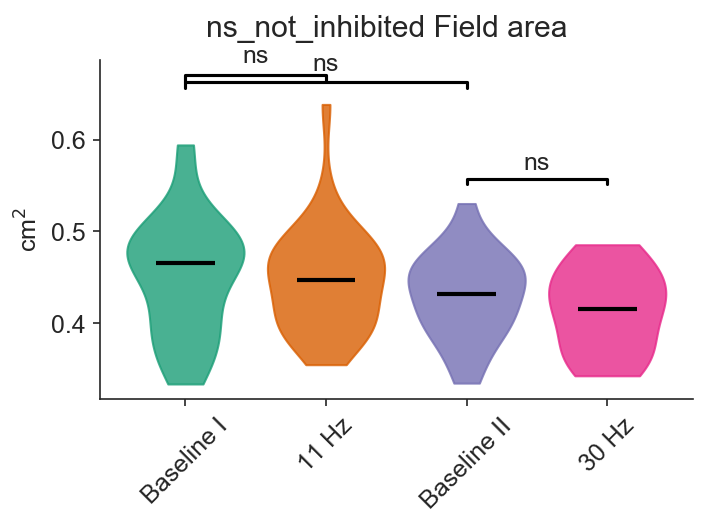

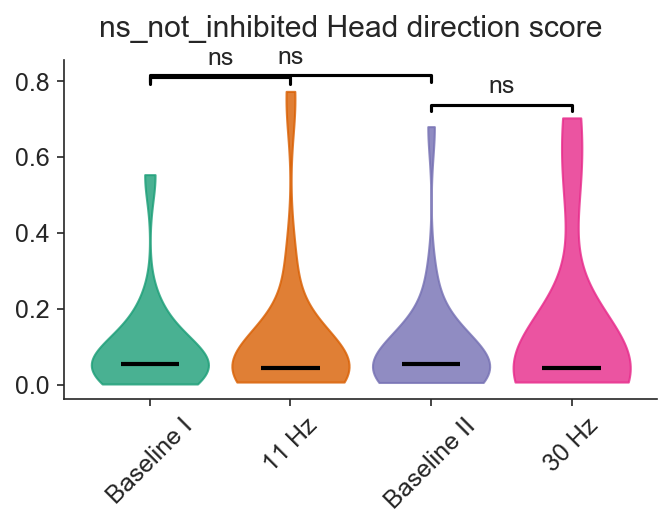

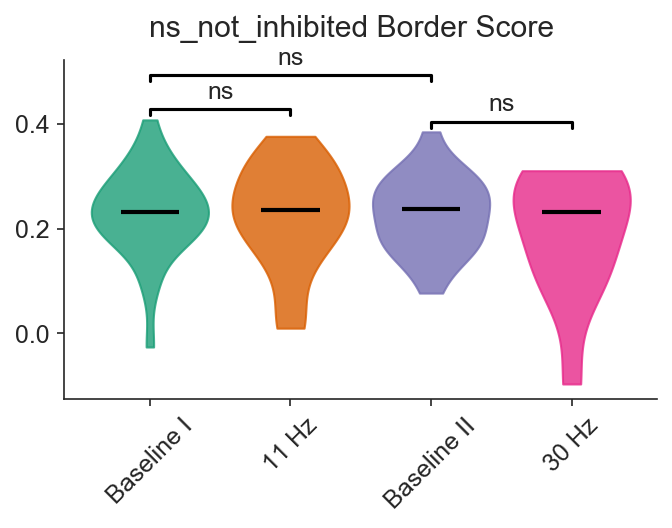

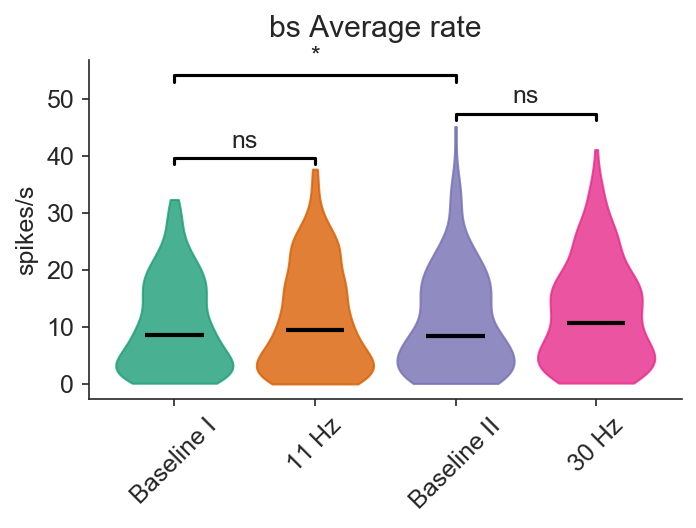

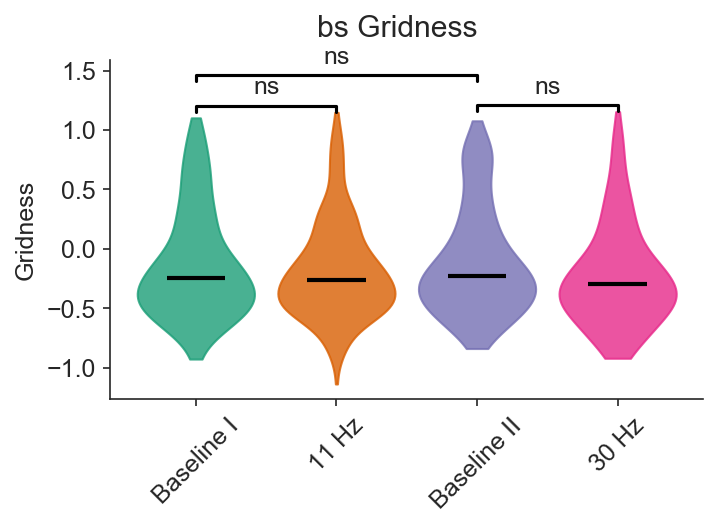

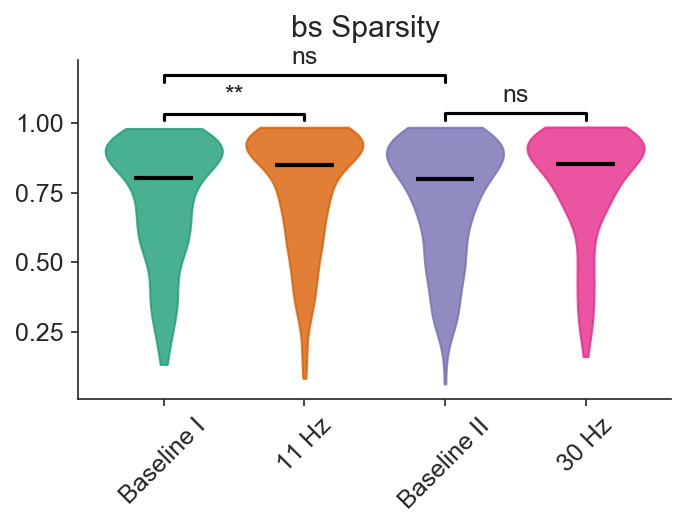

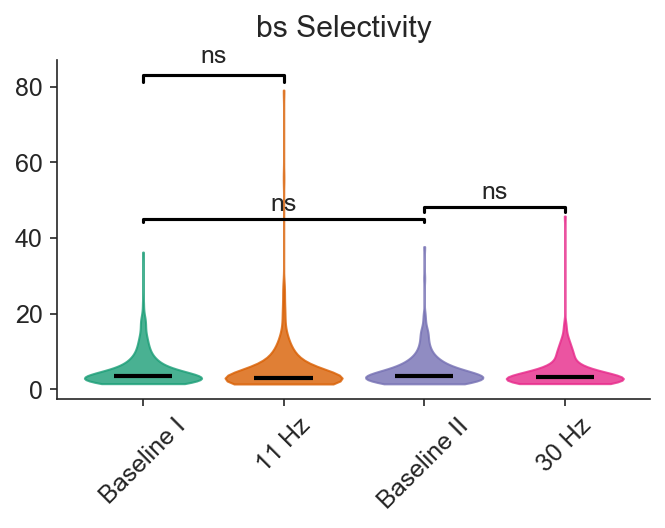

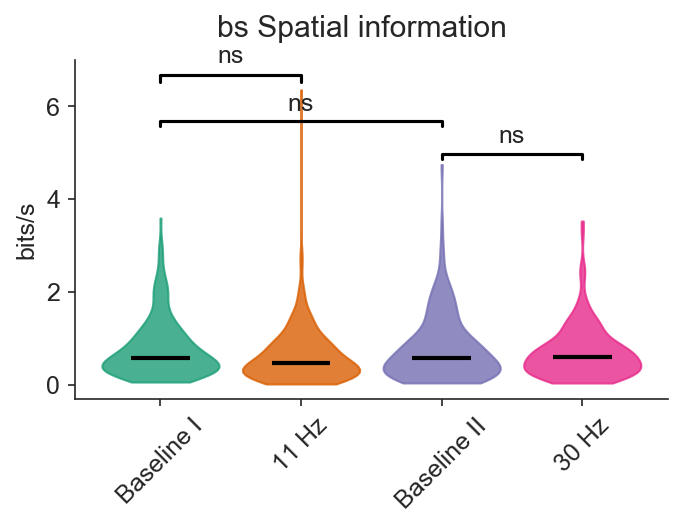

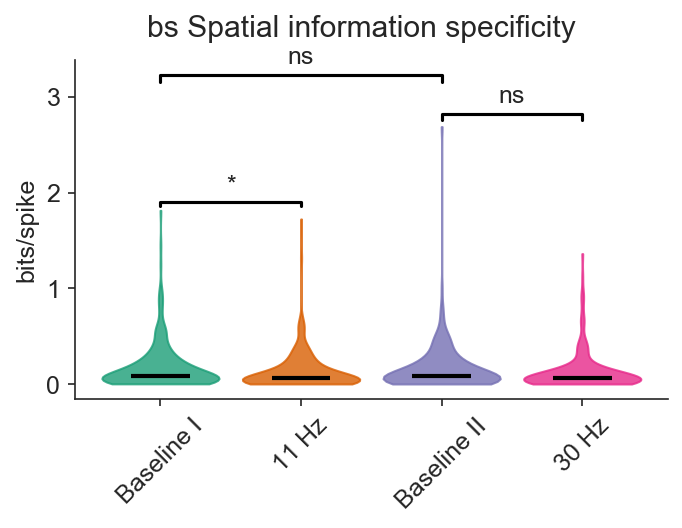

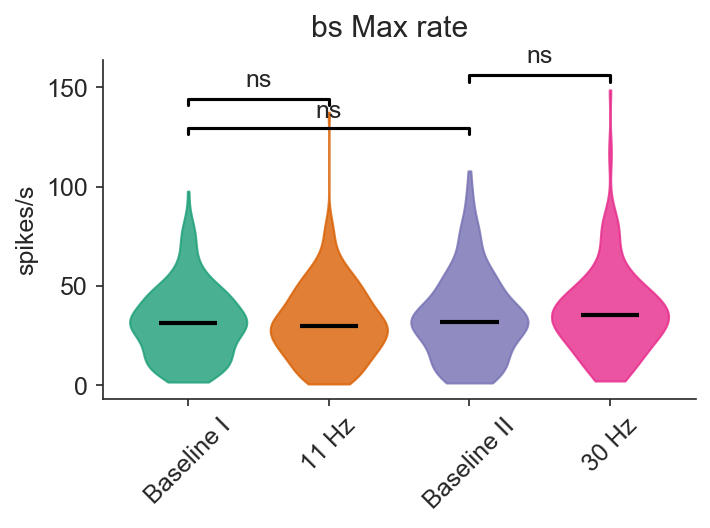

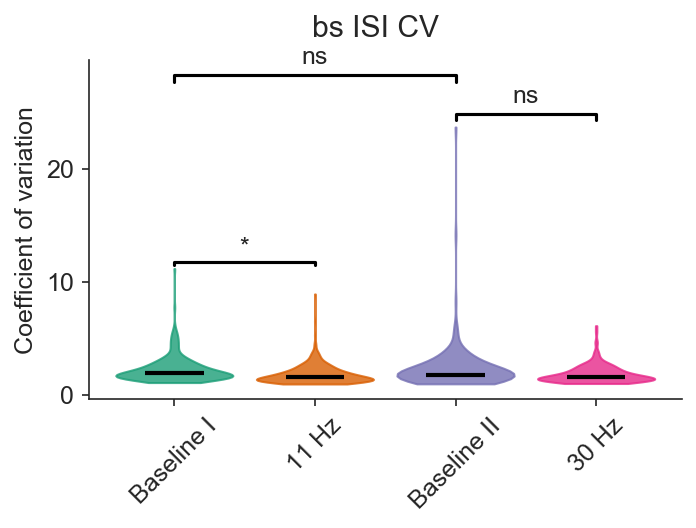

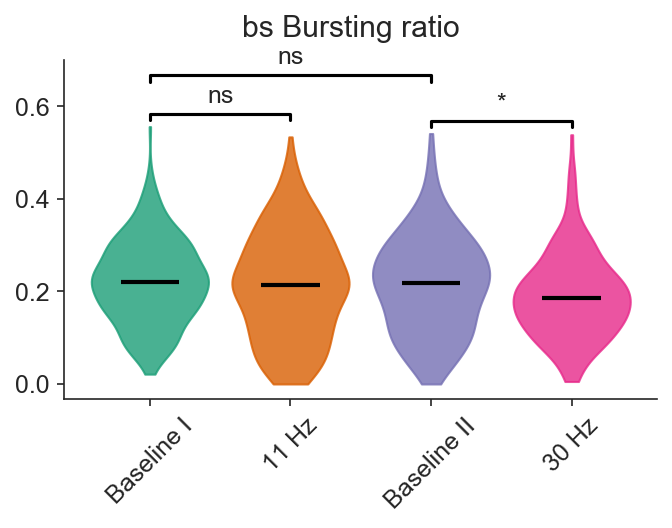

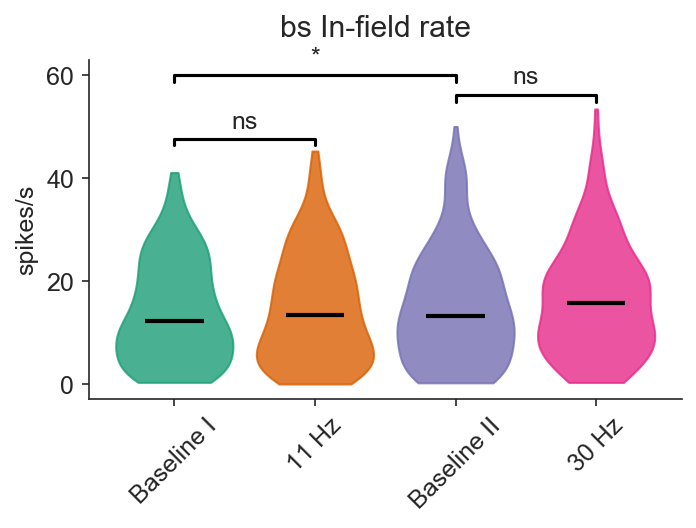

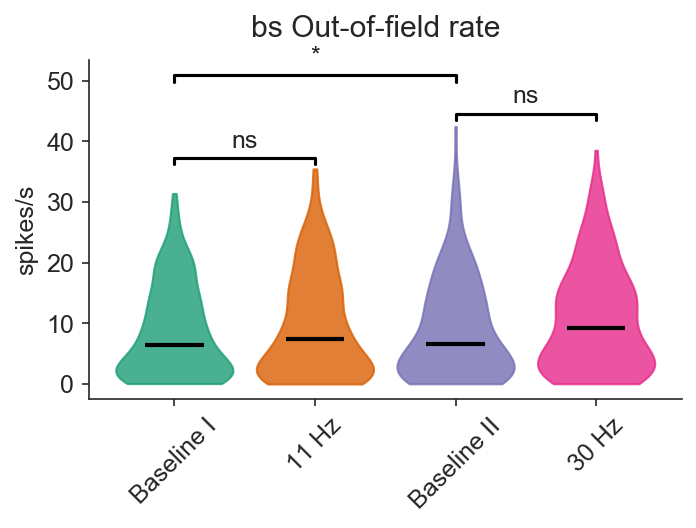

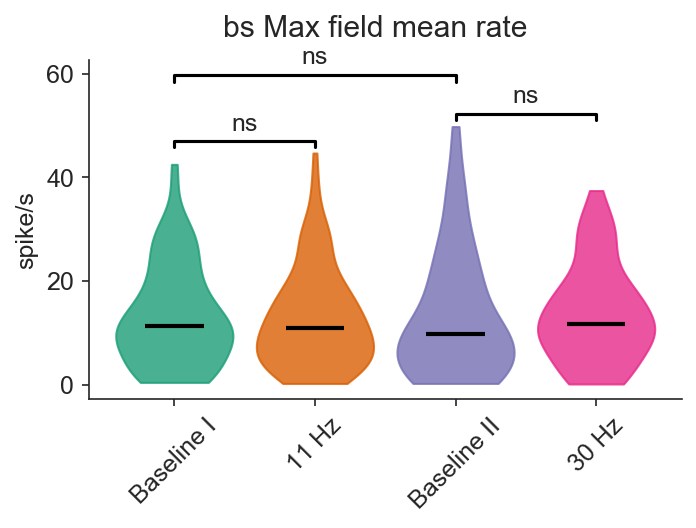

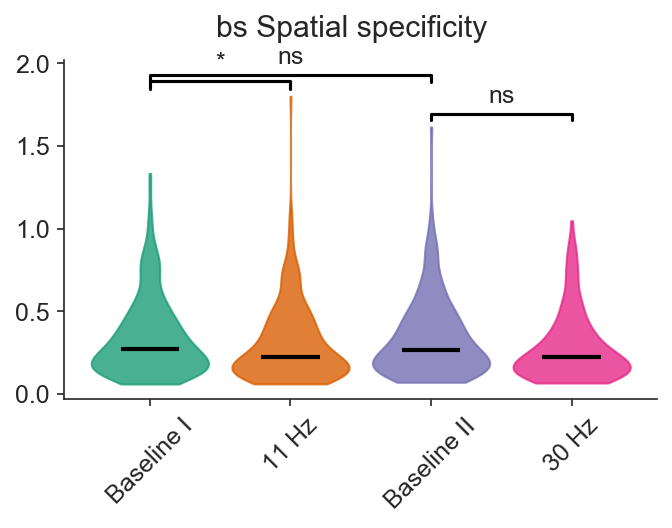

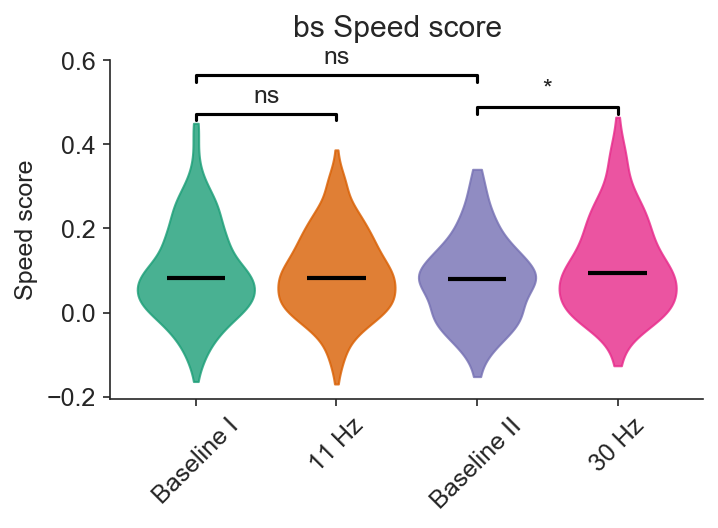

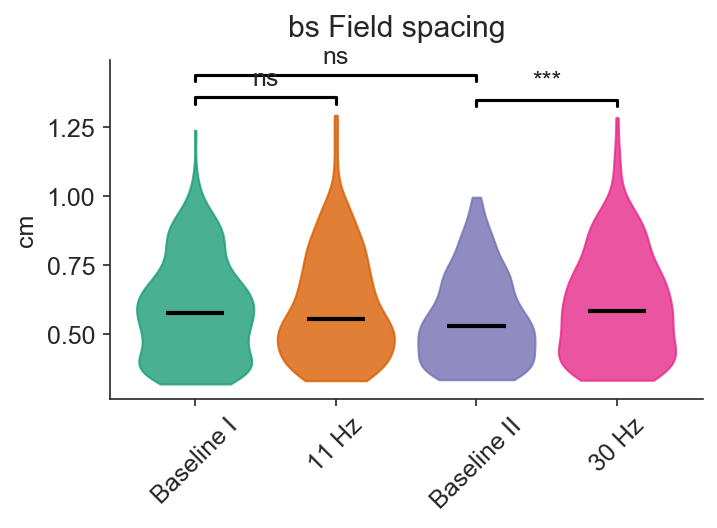

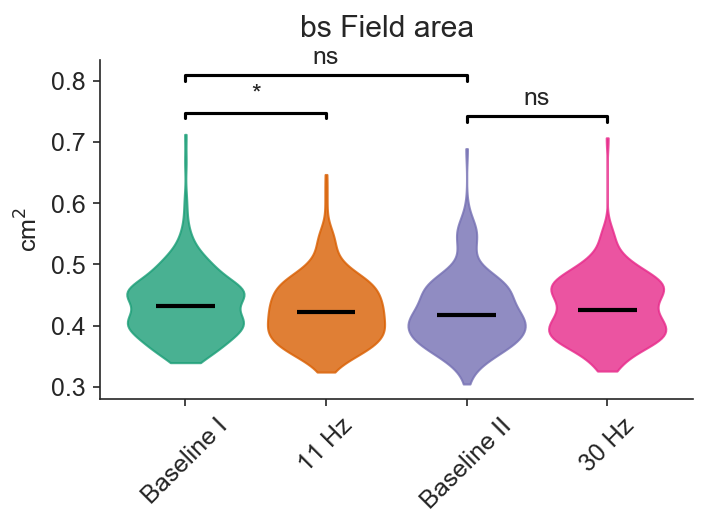

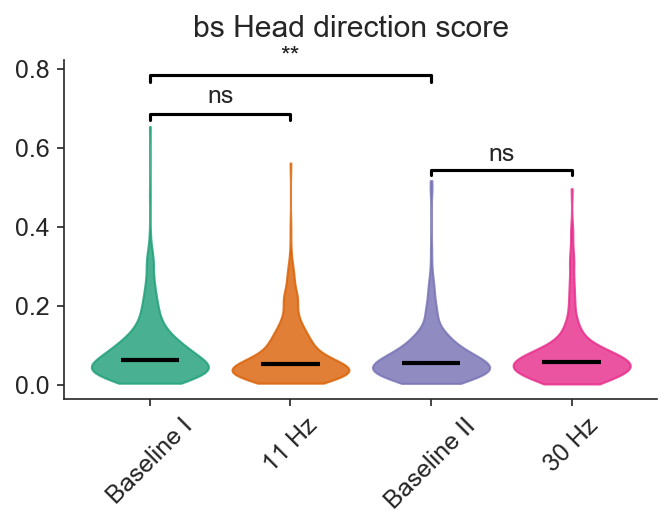

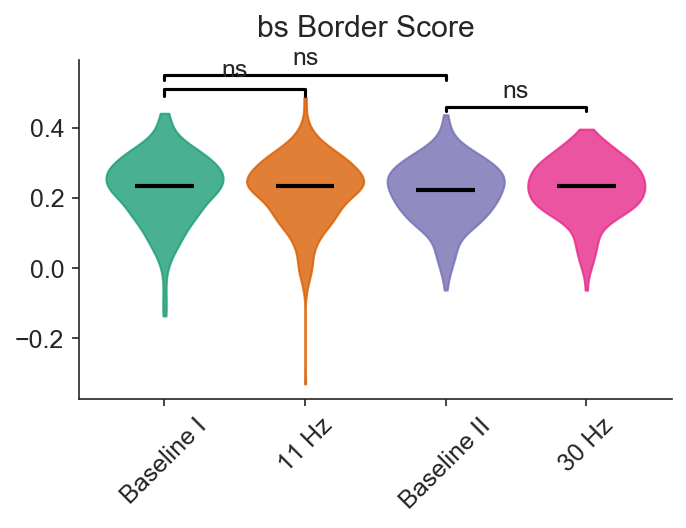

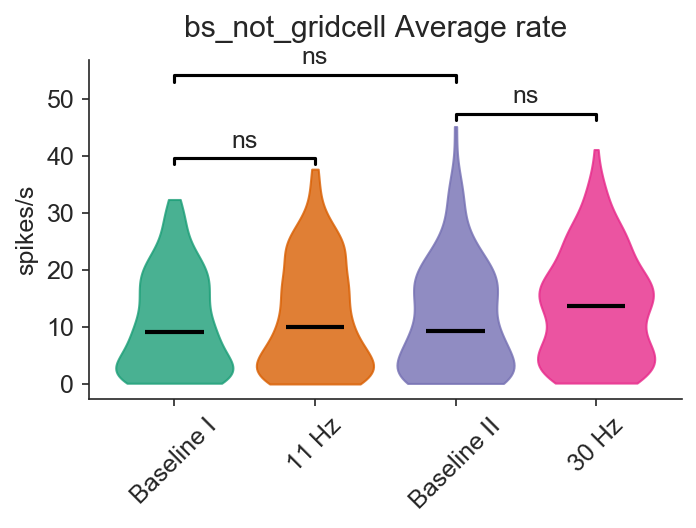

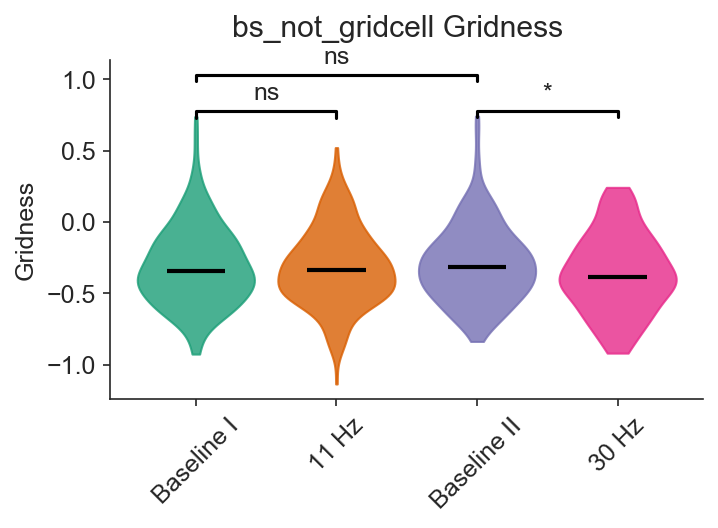

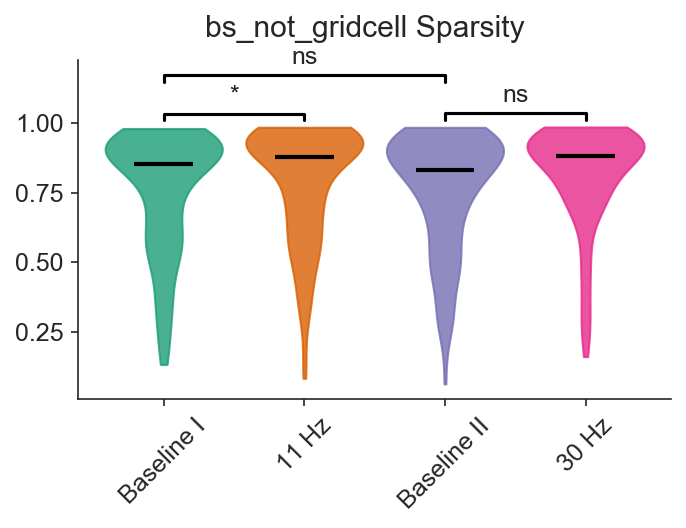

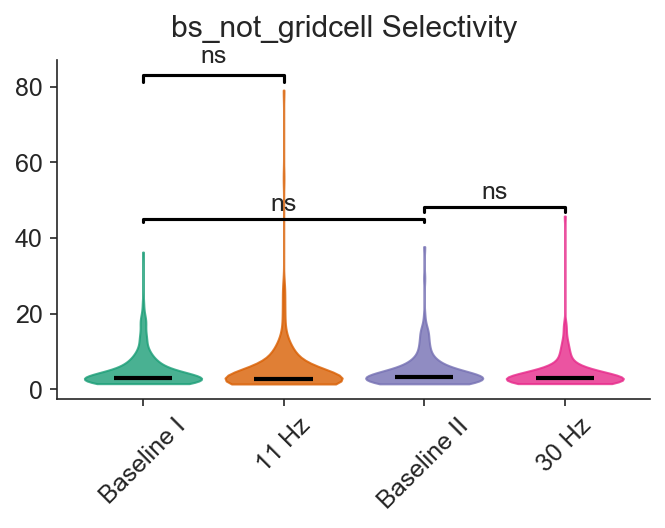

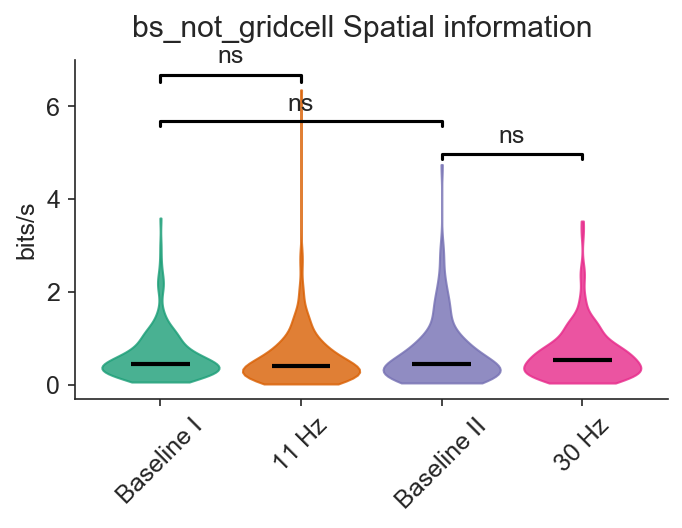

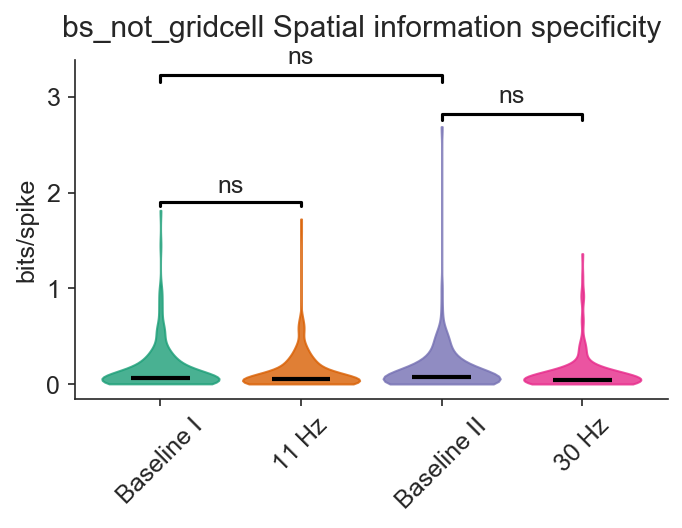

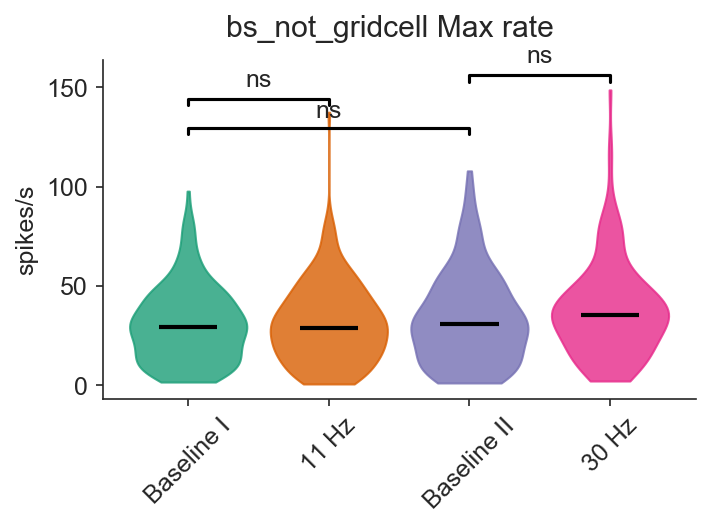

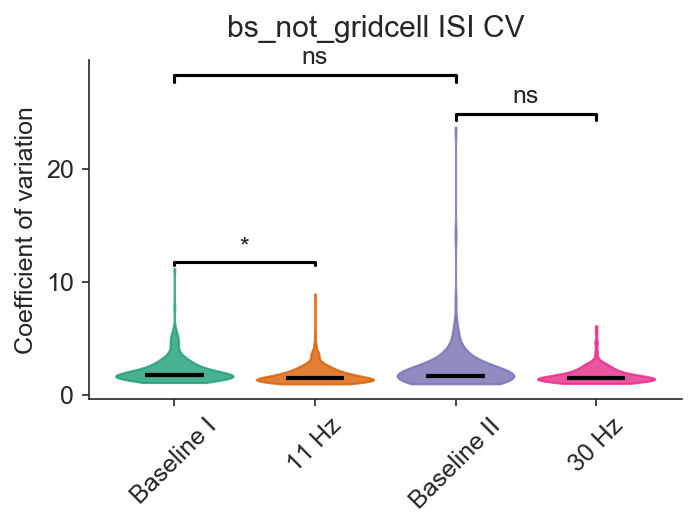

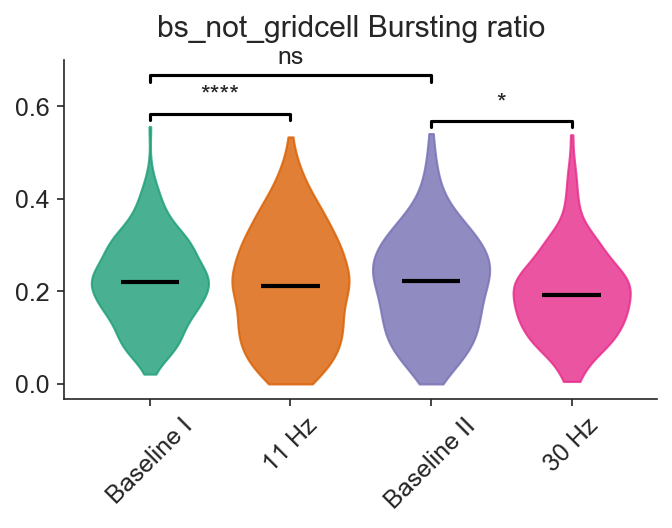

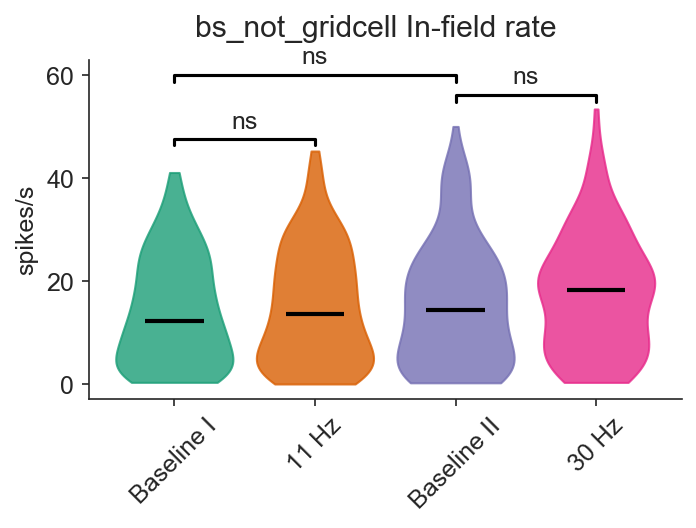

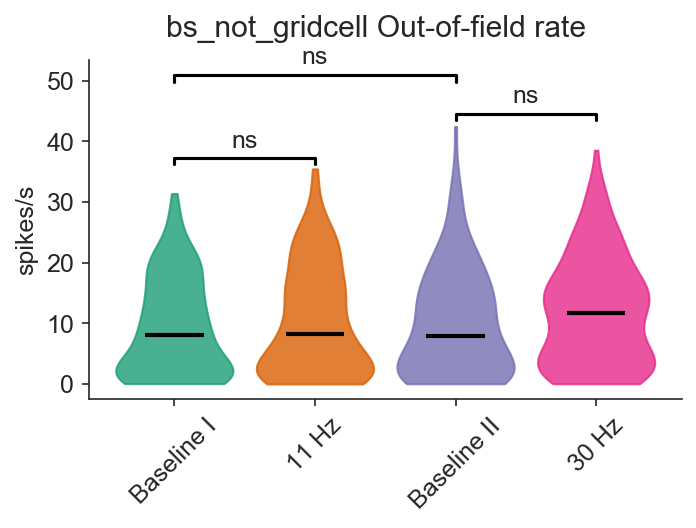

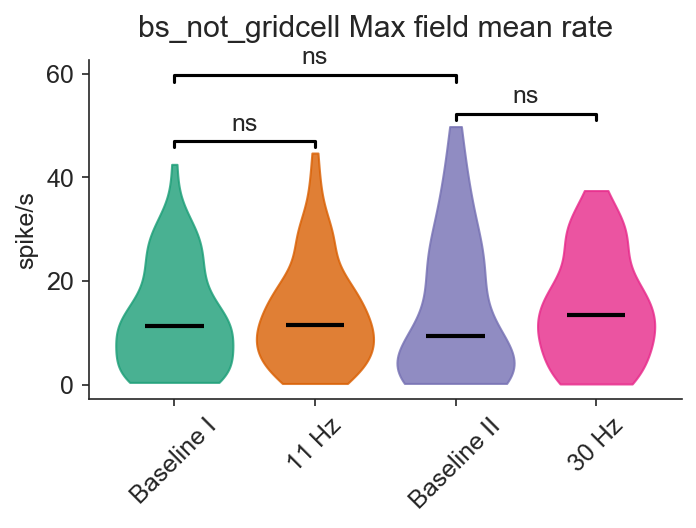

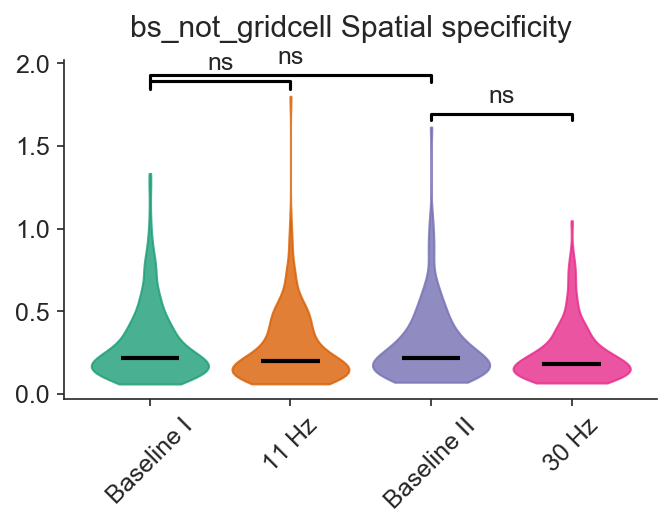

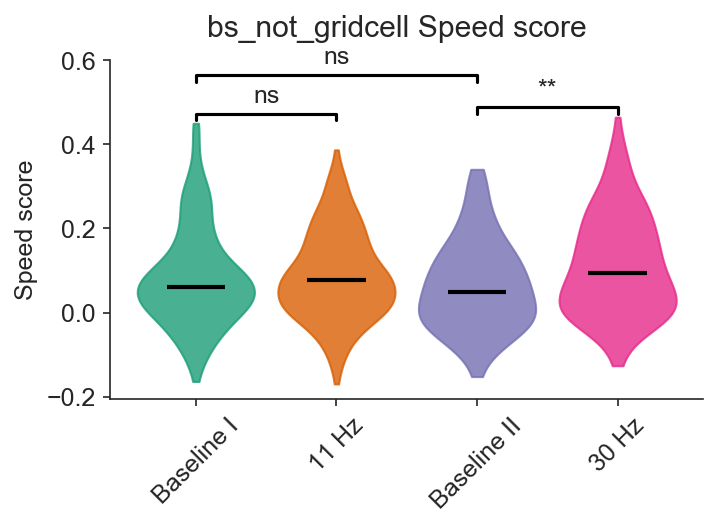

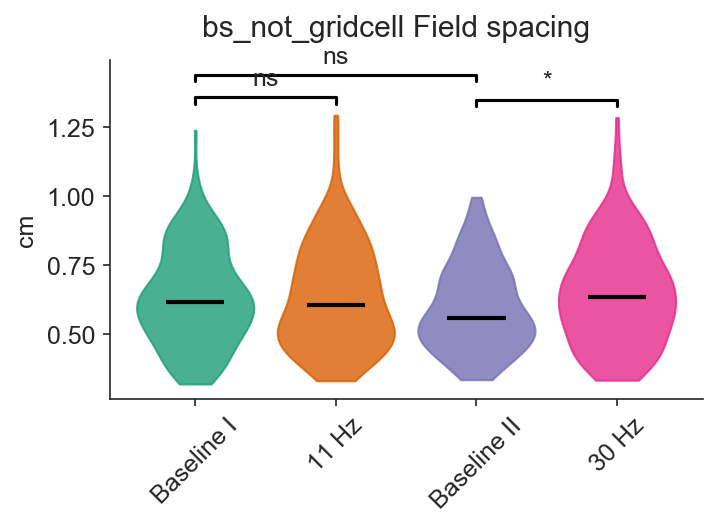

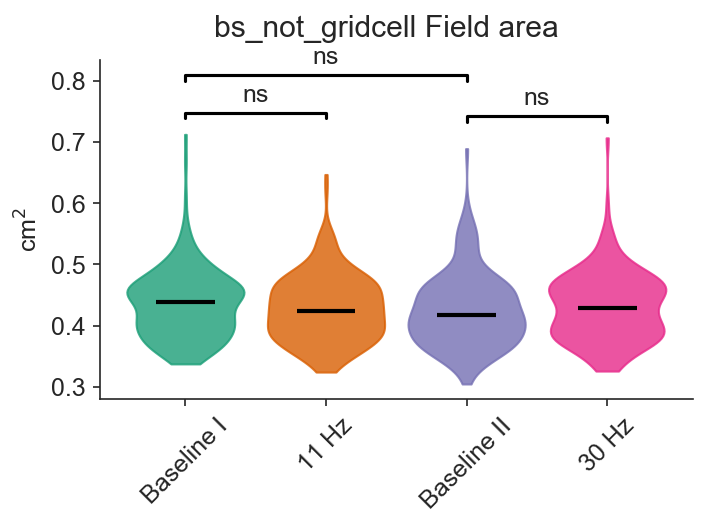

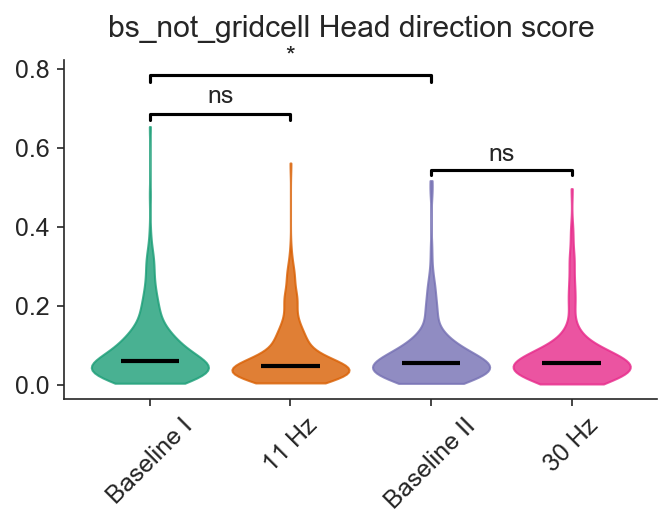

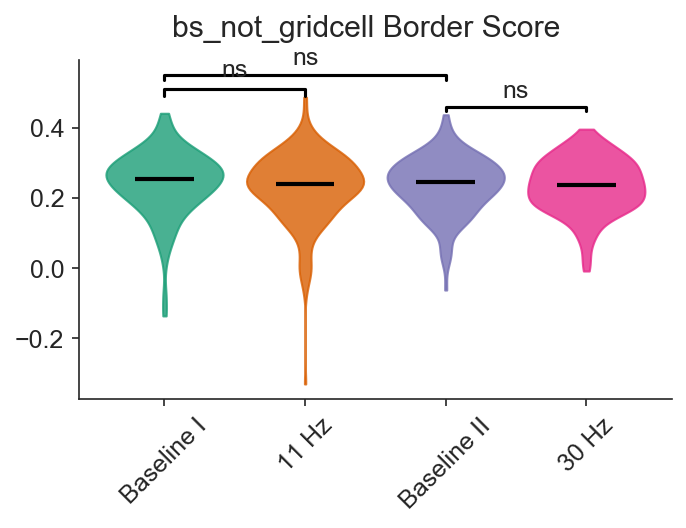

In [20]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        if key not in title_xlabel:
            continue
        fig = plt.figure()
        plt.suptitle(cell_type + ' ' + title_xlabel[key][0])
        violinplot(result, labels=labels, colors=colors, statistics=stat_values[cell_type][key])
        plt.ylabel(title_xlabel[key][1])
#         plt.tight_layout()
        plt.grid(False)
        despine()
        savefig(output_path / "figures" / f'{cell_type}_violin_{key}')

# Register in Expipe

In [21]:
action = project.require_action("comparisons-allcells")

In [22]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_ns_not_inhibited_head_mean_vec_len.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_ns_inhibited_border_score.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_bs_spacing.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_gridcell_field_area.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_bs_spatial_average_rate.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_ns_not_inhibited_information_rate.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_ns_inhibited_field_area.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_gridcell_sparsity.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/

In [23]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_allcells.ipynb")